In [1]:
# import modules

import sys
#sys.path.insert(0,"C:/Users/reinfurt/shap")
print(sys.version)

import os

mingw_path = 'C:\\Program Files\\Git\\mingw64\\bin'
graphviz_path = 'C:\\Inicio\\tools\\64\\Anaconda3-5.2.0.1\\Library\\bin\\graphviz'

os.environ['PATH'] = mingw_path + ';' + graphviz_path + ';' + os.environ['PATH']

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import shap
print(shap.__version__)
print(shap.__file__)

import scipy
from scipy import stats

import pickle

import datetime
from numba import jit
import math


3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


0.25.1
C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\shap\__init__.py


In [2]:
# load from pickle and be set

# Load the model from a pickle in a file
model_0815 = pickle.load( open( "final_model.p", "rb" ) )

# Load the explainer from a pickle in a file 
explainer_0815 = pickle.load( open( "final_explainer.p", "rb" ) )

# Load the shap values from a pickle in a file
shap_values_0815 = pickle.load( open( "final_shapValues.p", "rb" ) )

# Load the set from a pickle in a file
set_0815_shap = pickle.load( open( "final_set.p", "rb" ) )

# Load the test data from a pickle in a file
test_0815 = pickle.load( open( "final_testData.p", "rb" ) )

# Load the train data from a pickle in a file 
train_0815 = pickle.load( open( "final_trainData.p", "rb" ) )

# Load the entire data from a pickle in a file 
pre_train_0815 = pickle.load( open( "final_beforeSplitData.p", "rb" ) )

# Load the test labels from a pickle in a file
y_test_0815 = pickle.load( open( "final_testLabels.p", "rb" ) )

# Load the train labels from a pickle in a file
y_train_0815 = pickle.load( open( "final_trainLabels.p", "rb" ) )

# Load the test data reduced values from a pickle in a file
test_df_reduced = pickle.load( open( "final_testDataReduced.p", "rb" ) )

# Load the predict from a pickle in a file
predict = pickle.load( open( "final_prediction.p", "rb" ) )

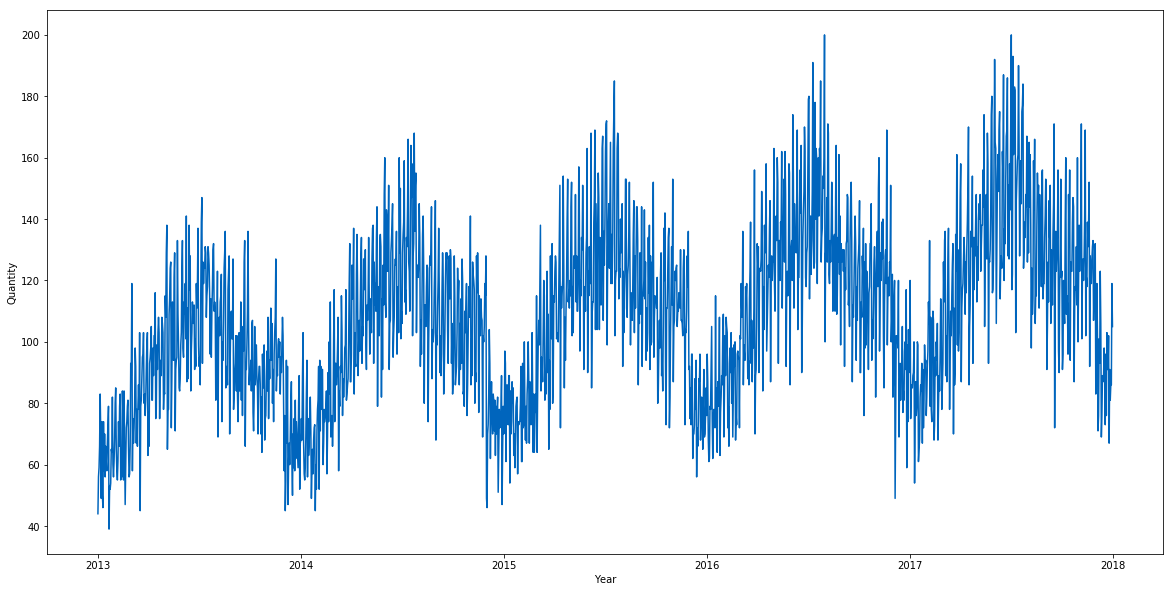

In [3]:

fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.plot(pre_train_0815['date'].values, pre_train_0815['sales'].values, color="#0065BD")
ax.set_ylabel("Quantity")
ax.set_xlabel("Year")
plt.rcParams.update({'font.size': 18})
#plt.gcf().autofmt_xdate()
# uncomment to save figure
#plt.savefig("timeSeriesSelect.pdf", bbox_inches="tight",pad_inches=0)
plt.show()


In [4]:
# seperate treatment groups
def sort_treatments(df):
    df_control = df[df['xai_chart_intro.1.player.ctrl_treat'] == 'control']
    df_treat3 = df[df['xai_chart_intro.1.player.ctrl_treat'] == 'treatment3']
    df_c_fb = df[df['xai_chart_intro.1.player.ctrl_treat'] == 'control_fb']
    df_t_fb = df[df['xai_chart_intro.1.player.ctrl_treat'] == 'treatment3_fb']
    return df_control, df_treat3, df_c_fb, df_t_fb

# get wrong count of intro questions
def extract_intro_understanding(df):  
    return df.filter(items=['participant.code'] + intro_columns_wrong_list).drop_duplicates()

# create string list to extract forecasting columns
def create_entire_list(string, str_list):
    list_return = []
    for i in range(30):
        for j in range(len(str_list)):
            str_append = string+'.'+str(i+1)+'.'+str_list[j]
            list_return.append(str_append)
    return list_return


# extract forecasting columns
def extract_forecasts(df, str_list):
    return df.filter(items = str_list)

def extract_mape_initial(df, mape_str):
    return df[mape_str]
    
def extract_mape_revised(df, mape_str):
    return df[mape_str]



In [5]:
# No adjustment
def no_adjustment(df_init, df_rev):
    df_return = df_init.copy()
    for i in range(df_init.shape[1]):
        df_return.iloc[:,i] = df_init.iloc[:,i] == df_rev.iloc[:,i]
    return df_return

# Adjustment towards algorithm
def go_with_algorithm(initial, revised, algorithm):
    dist_init_alg = algorithm - initial.values
    dist_init_rev = revised.values - initial.values
    dist_rev_alg = algorithm - revised.values
    dist_percentage = dist_init_alg.copy()
    dist_percentage[dist_init_alg != 0] = (abs(dist_init_alg[dist_init_alg != 0])-abs(dist_rev_alg[dist_init_alg != 0]))/abs(dist_init_alg[dist_init_alg != 0])
    dist_percentage[(dist_init_alg == 0) & (dist_init_rev == 0)] = float('NaN')
    dist_percentage[(dist_init_alg == 0) & (dist_init_rev != 0)] = -abs(dist_init_rev[(dist_init_alg == 0) & (dist_init_rev != 0)])/initial.values[(dist_init_alg == 0) & (dist_init_rev != 0)]
    return dist_percentage

# plot initial, revised and ML algorithm forecasts for all participants 
def plot_all_3(initial, revised, algorithm, x_range):
    x = range(x_range)
    for i in range(initial.shape[0]):        
        fig = plt.figure()
        ax = plt.axes()

        plt.plot(x, initial.iloc[i,:])
        plt.plot(x, revised.iloc[i,:])
        plt.plot(x, algorithm)

        plt.legend(['initial', 'revised', 'ML algorithm'], loc='upper right')

        plt.show()

def plot_all_4(initial, revised, algorithm, actual, x_range):
    x = range(x_range)
    for i in range(initial.shape[0]):        
        fig = plt.figure()
        ax = plt.axes()

        plt.plot(x, initial.iloc[i,:])
        plt.plot(x, revised.iloc[i,:])
        plt.plot(x, algorithm)
        plt.plot(x, actual)

        plt.legend(['initial', 'revised', 'ML algorithm', 'actual'], loc='upper right')

        plt.show()

# winzorizing to increase robustness
def apply_winzor(dist):
    dist_winzor = np.reshape(dist.copy(),(dist.shape[0]*dist.shape[1],1))
    scipy.stats.mstats.winsorize(dist_winzor, limits = 0.05, inplace = True)
    out = np.reshape(dist_winzor, (dist.shape[0], dist.shape[1]))
    return out

In [6]:
intro_columns_wrong_list = ['xai_chart_intro.1.player.aim_wrong', 'xai_chart_intro.1.player.mechanism1_wrong', 
                            'xai_chart_intro.1.player.mechanism2_wrong', 'xai_chart_intro.1.player.accuracy1_wrong',
                            'xai_chart_intro.1.player.accuracy2_wrong', 'xai_chart_intro.1.player.procedure_wrong']

xai_columns_wrong_list = ['xai_chart_intro.1.player.x1_wrong', 'xai_chart_intro.1.player.x2_wrong',
                          'xai_chart_intro.1.player.x3_wrong']

forecasts_list = ['xai_chart_experiment.1.player.ape_round', 'xai_chart_experiment.1.player.mape',
                  'xai_chart_experiment.1.player.ape_round_rev', 'xai_chart_experiment.1.player.mape_rev',
                  'xai_chart_experiment.1.subsession.ape_round_ml', 'xai_chart_experiment.1.subsession.mape_ml',
                  'xai_chart_experiment.1.player.F1_Initial', 'xai_chart_experiment.1.player.F1_Revised']

forecast_list_ending = ['player.ape_round', 'player.mape', 'player.ape_round_rev', 'player.mape_rev', 'subsession.ape_round_ml',
                        'subsession.mape_ml', 'player.F1_Initial', 'player.F1_Revised']

In [7]:
# load total experiment data of participants

total_data = pd.read_excel("./data/Total_both.xlsx")

In [8]:
# create extracted versions
def extract_all_normal(df, exp_str, list_ending):
    l_str = create_entire_list(exp_str, [list_ending[0]])
    init_ape = extract_forecasts(df, l_str)
    l_str = create_entire_list(exp_str, [list_ending[2]])
    rev_ape = extract_forecasts(df, l_str)
    l_str = create_entire_list(exp_str, [list_ending[6]])
    init_fcst = extract_forecasts(df, l_str)
    l_str = create_entire_list(exp_str, [list_ending[7]])
    rev_fcst = extract_forecasts(df, l_str)
    
    return init_ape, rev_ape, init_fcst, rev_fcst


    

In [9]:
# one time extracts
ml_forecasts = predict[228:228+30].round()
ml_forecasts_ape = extract_forecasts(total_data, create_entire_list('xai_chart_experiment', [forecast_list_ending[4]]))
actuals = y_test_0815[228:228+30].values



# total
init_ape_total, rev_ape_total, init_fcst_total, rev_fcst_total = extract_all_normal(total_data, 'xai_chart_experiment', forecast_list_ending) 
mape_initial = extract_mape_initial(total_data, 'xai_chart_experiment.30.player.mape')
mape_revised = extract_mape_revised(total_data, 'xai_chart_experiment.30.player.mape_rev')
# sort treatments and extract
df_ctrl, df_treat, df_ctrl_fb, df_treat_fb = sort_treatments(total_data)

# 1st round
init_ape_ctrl, rev_ape_ctrl, init_fcst_ctrl, rev_fcst_ctrl = extract_all_normal(df_ctrl, 'xai_chart_experiment', forecast_list_ending) 
init_ape_treat, rev_ape_treat, init_fcst_treat, rev_fcst_treat = extract_all_normal(df_treat, 'xai_chart_experiment', forecast_list_ending) 
mape_initial_ctrl = extract_mape_initial(df_ctrl, 'xai_chart_experiment.30.player.mape')
mape_revised_ctrl = extract_mape_revised(df_ctrl, 'xai_chart_experiment.30.player.mape_rev')
mape_initial_treat = extract_mape_initial(df_treat, 'xai_chart_experiment.30.player.mape')
mape_revised_treat = extract_mape_revised(df_treat, 'xai_chart_experiment.30.player.mape_rev')

# 2nd round (feedback check)
init_ape_ctrl_fb, rev_ape_ctrl_fb, init_fcst_ctrl_fb, rev_fcst_ctrl_fb = extract_all_normal(df_ctrl_fb, 'xai_chart_experiment', forecast_list_ending) 
init_ape_treat_fb, rev_ape_treat_fb, init_fcst_treat_fb, rev_fcst_treat_fb = extract_all_normal(df_treat_fb, 'xai_chart_experiment', forecast_list_ending) 
mape_initial_ctrl_fb = extract_mape_initial(df_ctrl_fb, 'xai_chart_experiment.30.player.mape')
mape_revised_ctrl_fb = extract_mape_revised(df_ctrl_fb, 'xai_chart_experiment.30.player.mape_rev')
mape_initial_treat_fb = extract_mape_initial(df_treat_fb, 'xai_chart_experiment.30.player.mape')
mape_revised_treat_fb = extract_mape_revised(df_treat_fb, 'xai_chart_experiment.30.player.mape_rev')


[Text(0,0.5,'Value'), Text(0.5,0,'Round')]

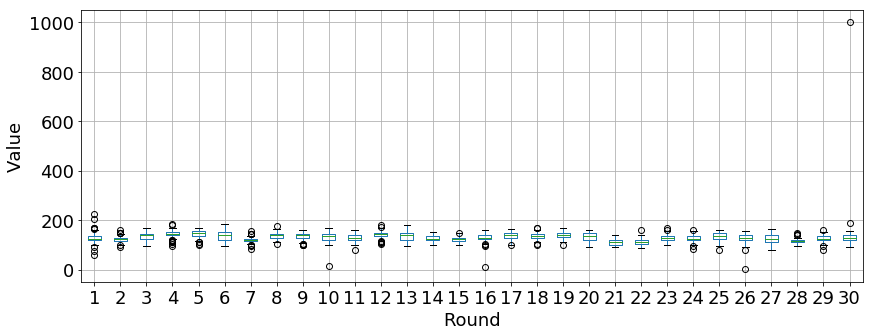

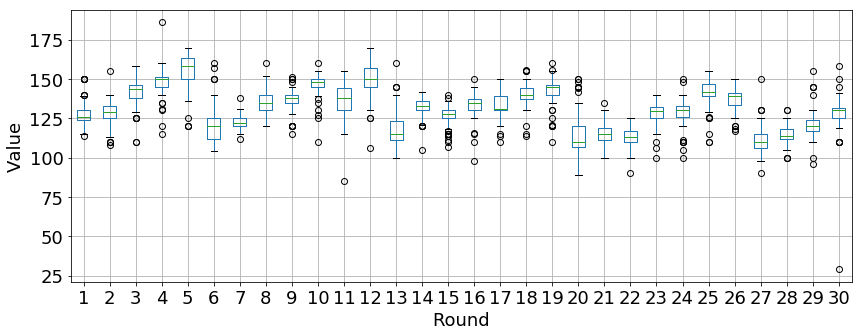

In [10]:
### box plots before and after removal ###
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1,1, figsize=(14,5)) # create figure and axes
box_total_init = init_fcst_total.rename(columns={x:y for x,y in zip(init_fcst_total.columns,range(1,31))}).boxplot()
axes.set(xlabel='Round', ylabel='Value')#, title="Boxplot initial forecast")

# uncomment so safe figure
#plt.savefig("boxplotBeforeRemoval1.pdf", bbox_inches="tight")

fig, axes = plt.subplots(1,1, figsize=(14,5)) # create figure and axes
box_total_rev = rev_fcst_total.rename(columns={x:y for x,y in zip(rev_fcst_total.columns,range(1,31))}).boxplot()
axes.set(xlabel='Round', ylabel='Value')#, title="Boxplot revised forecast")
# uncomment so safe figure
#plt.savefig("boxplotBeforeRemoval2.pdf", bbox_inches="tight")

In [11]:
### z-scores outlier detection ###

z = np.abs(stats.zscore(init_fcst_total.values.reshape(84*30,1)))
z_re = z.reshape(84,30)

z_rev = np.abs(stats.zscore(rev_fcst_total.values.reshape(84*30,1)))
z_rev_re = z_rev.reshape(84,30)

print("For initial forecast:")
print("actual values:", init_fcst_total.iloc[np.where(z_re>4)[0],np.where(z_re>4)[1]])
print("z-values:", z_re[np.where(z_re>4)])
print("position in data frame:", np.where(z_re>4))

print("For revised forecast:")
print("actual values:", rev_fcst_total.iloc[np.where(z_rev_re>4)[0],np.where(z_rev_re>4)[1]])
print("z-values:", z_rev_re[np.where(z_rev_re>4)])
print("position in data frame:", np.where(z_rev_re>4))

For initial forecast:
actual values:     xai_chart_experiment.16.player.F1_Initial  \
16                                         11   
19                                        125   
34                                        135   
68                                        130   

    xai_chart_experiment.26.player.F1_Initial  \
16                                        135   
19                                          1   
34                                        140   
68                                        130   

    xai_chart_experiment.30.player.F1_Initial  \
16                                        115   
19                                        130   
34                                       1000   
68                                        115   

    xai_chart_experiment.10.player.F1_Initial  
16                                        128  
19                                        140  
34                                        115  
68                               

In [12]:
### outlier replacement ###

total_data_outlier = total_data.copy()

# player 17 initial forecast 16 (11) <= initial forecast 15 (136)
total_data_outlier.loc[total_data_outlier.index[16],'xai_chart_experiment.16.player.F1_Initial']  = total_data['xai_chart_experiment.15.player.F1_Initial'][16]

# player 20 initial forecast 26 (1) <= initial forecast 25 (150)
total_data_outlier.loc[total_data_outlier.index[19],'xai_chart_experiment.26.player.F1_Initial']  = total_data['xai_chart_experiment.25.player.F1_Initial'][19]

# player 35 initial forecast 30 (1000) <= initial forecast 29 (140)
total_data_outlier.loc[total_data_outlier.index[34],'xai_chart_experiment.30.player.F1_Initial']  = total_data['xai_chart_experiment.29.player.F1_Initial'][34]

# player 69 initial forecast 10 (14) <= initial forecast 9 (140)
total_data_outlier.loc[total_data_outlier.index[68],'xai_chart_experiment.10.player.F1_Initial']  = total_data['xai_chart_experiment.9.player.F1_Initial'][68]


# player 10 revised forecast 30 <= 129 insted of 29 (assumption that missing "1" is a typo, in other rounds also mostly in between ML and initial)
total_data_outlier.loc[total_data_outlier.index[9],'xai_chart_experiment.30.player.F1_Revised'] = 129


In [13]:
### data extraction of forecasts after outlier replacement ###

# one time extracts
ml_forecasts = predict[228:228+30].round()
ml_forecasts_ape = extract_forecasts(total_data_outlier, create_entire_list('xai_chart_experiment', [forecast_list_ending[4]]))
actuals = y_test_0815[228:228+30].values



# total
init_ape_total, rev_ape_total, init_fcst_total, rev_fcst_total = extract_all_normal(total_data_outlier, 'xai_chart_experiment', forecast_list_ending) 
mape_initial = extract_mape_initial(total_data_outlier, 'xai_chart_experiment.30.player.mape')
mape_revised = extract_mape_revised(total_data_outlier, 'xai_chart_experiment.30.player.mape_rev')
# sort treatments and extract
df_ctrl, df_treat, df_ctrl_fb, df_treat_fb = sort_treatments(total_data_outlier)

# 1st round
init_ape_ctrl, rev_ape_ctrl, init_fcst_ctrl, rev_fcst_ctrl = extract_all_normal(df_ctrl, 'xai_chart_experiment', forecast_list_ending) 
init_ape_treat, rev_ape_treat, init_fcst_treat, rev_fcst_treat = extract_all_normal(df_treat, 'xai_chart_experiment', forecast_list_ending) 
mape_initial_ctrl = extract_mape_initial(df_ctrl, 'xai_chart_experiment.30.player.mape')
mape_revised_ctrl = extract_mape_revised(df_ctrl, 'xai_chart_experiment.30.player.mape_rev')
mape_initial_treat = extract_mape_initial(df_treat, 'xai_chart_experiment.30.player.mape')
mape_revised_treat = extract_mape_revised(df_treat, 'xai_chart_experiment.30.player.mape_rev')

# 2nd round (feedback check)
init_ape_ctrl_fb, rev_ape_ctrl_fb, init_fcst_ctrl_fb, rev_fcst_ctrl_fb = extract_all_normal(df_ctrl_fb, 'xai_chart_experiment', forecast_list_ending) 
init_ape_treat_fb, rev_ape_treat_fb, init_fcst_treat_fb, rev_fcst_treat_fb = extract_all_normal(df_treat_fb, 'xai_chart_experiment', forecast_list_ending) 
mape_initial_ctrl_fb = extract_mape_initial(df_ctrl_fb, 'xai_chart_experiment.30.player.mape')
mape_revised_ctrl_fb = extract_mape_revised(df_ctrl_fb, 'xai_chart_experiment.30.player.mape_rev')
mape_initial_treat_fb = extract_mape_initial(df_treat_fb, 'xai_chart_experiment.30.player.mape')
mape_revised_treat_fb = extract_mape_revised(df_treat_fb, 'xai_chart_experiment.30.player.mape_rev')

In [14]:
age_dict = [
            [0, '<18'],
            [1, '18-19'],
            [2, '20-21'],
            [3, '22-23'],
            [4, '24-25'],
            [5, '26-27'],
            [6, '28-29'],
            [7, '30-31'],
            [8, '32-33'],
            [9, '34-35'],
            [10, '36-37'],
            [11, '38-39'],
            [12, '40-41'],
            [13, '42-43'],
            [14, '44-45'],
            [15, '46-47'],
            [16, '48-49'],
            [17, '50-51'],
            [18, '52-53'],
            [19, '54-55'],
            [20, '56-57'],
            [21, '58-59'],
            [22, '60-61'],
            [23, '62-63'],
            [24, '64-65'],
            [25, '66-67'],
            [26, '68-69'],
            [27, '70-71'],
            [28, '72-73'],
            [29, '74-75'],
            [30, '76-77'],
            [31, '78-79'],
            [32, '80-81'],
            [33, '>81']
        ]

age_dict2 = [
            [17, '<18'],
            [1, '18-19'],
            [20.5, '20-21'],
            [22.5, '22-23'],
            [24.5, '24-25'],
            [26.5, '26-27'],
            [28.5, '28-29'],
            [30.5, '30-31'],
            [8, '32-33'],
            [34.5, '34-35'],
            [10, '36-37'],
            [38.5, '38-39'],
            [12, '40-41'],
            [13, '42-43'],
            [14, '44-45'],
            [15, '46-47'],
            [16, '48-49'],
            [17, '50-51'],
            [18, '52-53'],
            [19, '54-55'],
            [56.5, '56-57'],
            [21, '58-59'],
            [22, '60-61'],
            [23, '62-63'],
            [24, '64-65'],
            [25, '66-67'],
            [26, '68-69'],
            [27, '70-71'],
            [28, '72-73'],
            [29, '74-75'],
            [30, '76-77'],
            [31, '78-79'],
            [32, '80-81'],
            [33, '>81']
        ]

In [15]:
### extract gender and age ###
gender_total = total_data_outlier.loc[:,'xai_chart_postquestionnaire.1.player.gender']
gender_ctrl = df_ctrl.loc[:,'xai_chart_postquestionnaire.1.player.gender']
gender_treat = df_treat.loc[:,'xai_chart_postquestionnaire.1.player.gender']
gender_ctrl_fb =df_ctrl_fb.loc[:,'xai_chart_postquestionnaire.1.player.gender']
gender_treat_fb = df_treat_fb.loc[:,'xai_chart_postquestionnaire.1.player.gender']

age_total = total_data_outlier.loc[:,'xai_chart_postquestionnaire.1.player.age']
age_ctrl = df_ctrl.loc[:,'xai_chart_postquestionnaire.1.player.age']
age_treat = df_treat.loc[:,'xai_chart_postquestionnaire.1.player.age']
age_ctrl_fb =df_ctrl_fb.loc[:,'xai_chart_postquestionnaire.1.player.age']
age_treat_fb = df_treat_fb.loc[:,'xai_chart_postquestionnaire.1.player.age']



In [16]:
def string_and_float_age(df_age, dict1, dict2):
    age_sort = df_age.copy()
    age_sort.values.sort()

    age_string = df_age.copy()
    for a in range(len(age_sort)):
        age_string.iloc[a] = dict1[age_sort.values[a]][1]

    age_float = df_age.copy()
    age_float = np.empty([len(age_sort),1], dtype=float)
    for a in range(len(age_sort)):
        age_float[a] = dict2[age_sort.values[a]][0]
    
    return age_string, age_float

age_total_s, age_total_f = string_and_float_age(age_total, age_dict, age_dict2)
age_ctrl_s, age_ctrl_f = string_and_float_age(age_ctrl, age_dict, age_dict2)
age_treat_s, age_treat_f = string_and_float_age(age_treat, age_dict, age_dict2)
age_ctrl_fb_s, age_ctrl_fb_f = string_and_float_age(age_ctrl_fb, age_dict, age_dict2)
age_treat_fb_s, age_treat_fb_f = string_and_float_age(age_treat_fb, age_dict, age_dict2)

print("Means:", age_total_f.mean(), age_ctrl_f.mean(), age_treat_f.mean(), age_ctrl_fb_f.mean(), age_treat_fb_f.mean())
print("Std:", age_total_f.std(), age_ctrl_f.std(), age_treat_f.std(), age_ctrl_fb_f.std(), age_treat_fb_f.std())



Means: 25.863095238095237 25.1 25.104166666666668 28.0 25.4
Std: 4.451023952870277 2.2891046284519194 3.38802783915494 7.372245248226622 1.9467922333931782


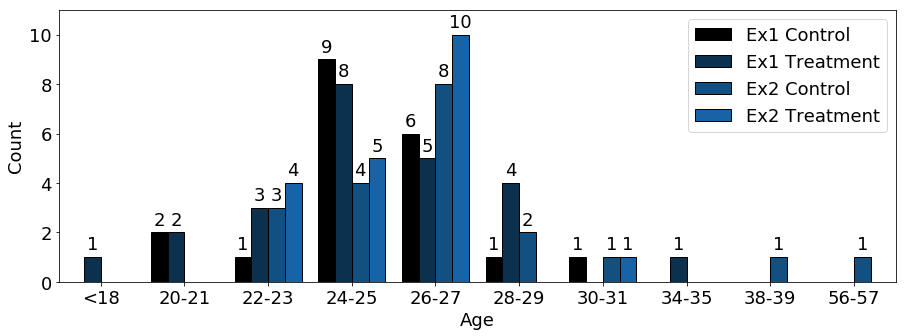

In [18]:
### gender split diagram ###

import seaborn as sns

tick_labels = ['<18','20-21','22-23', '24-25', '26-27', '28-29', '30-31', '34-35', '38-39', '56-57']

plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(15,5))
ax = sns.countplot(x='xai_chart_postquestionnaire.1.player.age', hue='xai_chart_intro.1.player.ctrl_treat',
                   data=total_data_outlier, palette =["#000000","#003359" , "#005293", "#0065BD",],
                  linewidth=1, edgecolor="black")
ax.set(xlabel='Age', ylabel='Count')#, title="Age histogram for all groups")
ax.set_xticklabels(tick_labels)
ax.legend(labels=['Ex1 Control', 'Ex1 Treatment', 'Ex2 Control', 'Ex2 Treatment'], loc='upper right')
ax.set_ylim([0, 11])
for p in ax.patches:
    height = p.get_height()
    if height.is_integer():
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.3,
                '%d'%int(height),
                ha="center") 
plt.rcParams.update({'font.size': 18})
# uncomment so safe figure
#plt.savefig("ageHistogramGroups.eps", bbox_inches="tight")

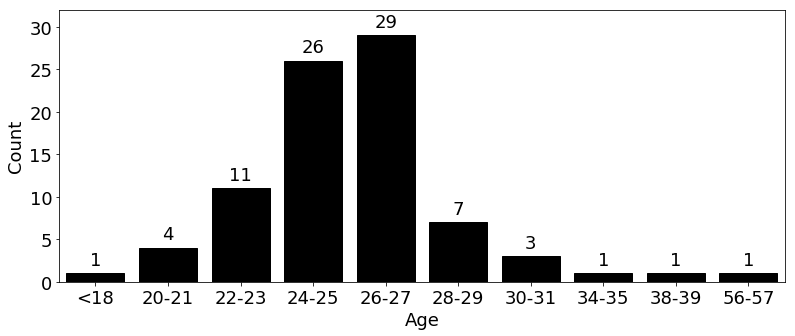

In [19]:
### age total ###
fig = plt.figure(figsize=(13,5))
ax = sns.countplot(x='xai_chart_postquestionnaire.1.player.age',
                   data=total_data_outlier, palette =["#000000"],
                  linewidth=1, edgecolor="black")
ax.set(xlabel='Age', ylabel='Count')#, title="Age histogram")
ax.set_xticklabels(tick_labels)
ax.set_ylim([0,32])
#ax.legend(labels=['Total'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 1,
            '%d'%int(height),
            ha="center") 
plt.rcParams.update({'font.size': 18})
# uncomment so safe figure
#plt.savefig("ageHistogramTotal.eps", bbox_inches="tight")

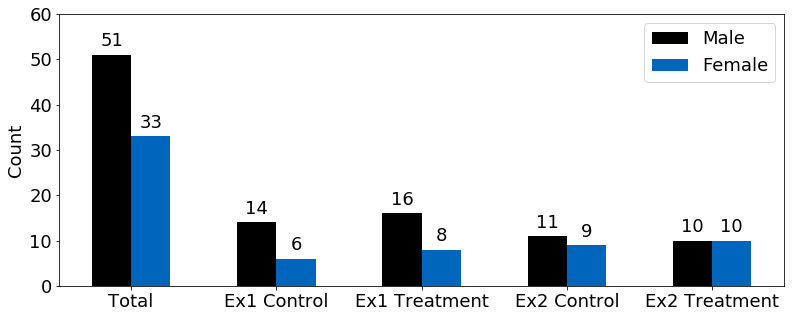

In [20]:
### gender total ###

from matplotlib.dates import date2num
import datetime

N = 5
ind = np.arange(N)  # the x locations for the groups
width = 0.27       # the width of the bars

fig = plt.figure(figsize=(13,5))
ax = fig.add_subplot(111)

yvals = [gender_total.sum(), gender_ctrl.sum(), gender_treat.sum(), gender_ctrl_fb.sum(), gender_treat_fb.sum()]
rects1 = ax.bar(ind, yvals, width, color='#000000')
kvals = [len(gender_total)-gender_total.sum(), len(gender_ctrl)-gender_ctrl.sum(), len(gender_treat)-gender_treat.sum(),
         len(gender_ctrl_fb)-gender_ctrl_fb.sum(), len(gender_treat_fb)-gender_treat_fb.sum()]
rects2 = ax.bar(ind+width, kvals, width, color='#0065BD')

#ax.set_title('Gender distribution')
ax.set_ylabel('Count')
ax.set_ylim([0,60])
ax.set_xticks(ind+width/2)
ax.set_xticklabels( ('Total', 'Ex1 Control', 'Ex1 Treatment', 'Ex2 Control', 'Ex2 Treatment') )
ax.legend( (rects1[0],rects2[0]), ('Male', 'Female') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1+ h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.rcParams.update({'font.size': 18})
plt.show()
# uncomment so safe figure
#fig.savefig("genderPlotNumbers.eps", bbox_inches="tight")

[Text(0,0.5,'Value'), Text(0.5,0,'Round')]

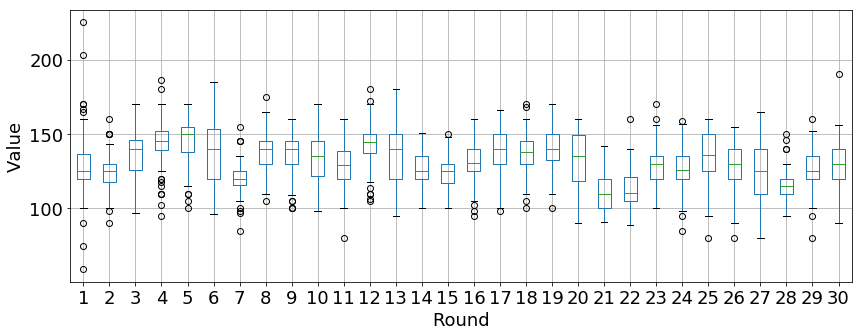

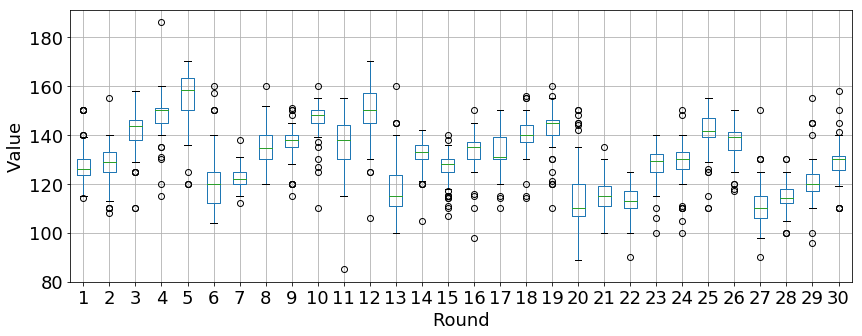

In [21]:
### box plots after removal ###
plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1,1, figsize=(14,5)) # create figure and axes
box_total_init = init_fcst_total.rename(columns={x:y for x,y in zip(init_fcst_total.columns,range(1,31))}).boxplot()
axes.set(xlabel='Round', ylabel='Value')#, title="Boxplot initial forecast")
# uncomment so safe figure
#plt.savefig("boxplotAfterRemoval1.pdf", bbox_inches="tight")

fig, axes = plt.subplots(1,1, figsize=(14,5)) # create figure and axes
box_total_rev = rev_fcst_total.rename(columns={x:y for x,y in zip(rev_fcst_total.columns,range(1,31))}).boxplot()
axes.set(xlabel='Round', ylabel='Value')#, title="Boxplot revised forecast")
# uncomment so safe figure
#plt.savefig("boxplotAfterRemoval2.pdf", bbox_inches="tight")

In [22]:
### plot initial, revised and ML algorithm forecasts for averaged participants ##
def plot_all_3_avg(initial, revised, algorithm, x_range):
    x = range(x_range) 
    fig = plt.figure(figsize=(15,7))
    ax = plt.axes()
    ax.set(xlabel='Round', ylabel='Value')#, title="Forecasts")
    plt.plot(x, initial, marker='o',linestyle='--', color= '#E37222')
    plt.plot(x, revised, marker='o', linestyle=':',color ='#0065BD')
    plt.plot(x, algorithm, marker='o', color='black')

    plt.legend(['Initial', 'Revised', 'ML algorithm'], loc='upper right')
    plt.rcParams.update({'font.size': 18})
    #plt.show()

def plot_all_4_avg(initial, revised, algorithm, actual, x_range):
    x = range(x_range)
        
    fig = plt.figure(figsize=(15,7))
    ax = plt.axes()
    ax.set(xlabel='Round', ylabel='Value')#, title="Forecasts")
    plt.plot(x, initial, marker='o',linestyle='--', color= '#E37222')
    plt.plot(x, revised, marker='o', linestyle=':',color ='#0065BD')
    plt.plot(x, algorithm, marker='o', color='black')
    plt.plot(x, actual, marker='*', linestyle=':',color ='black')

    plt.legend(['Initial', 'Revised', 'ML algorithm', 'Actual'], ncol=2, loc='upper right')

    #plt.show()

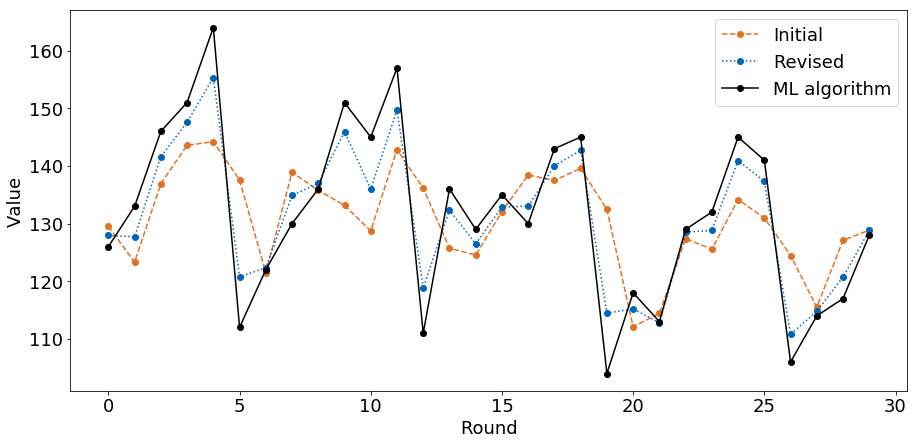

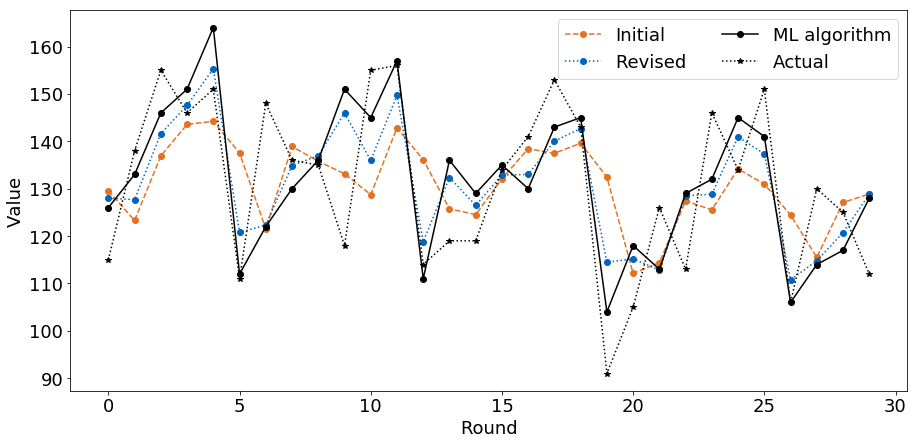

In [23]:
### plot forecasts ###
plot_all_3_avg(init_fcst_total.mean(0).values, rev_fcst_total.mean(0).values, ml_forecasts,  30)
# uncomment so safe figure
#plt.savefig("3forecast.eps", bbox_inches="tight")
plot_all_4_avg(init_fcst_total.mean(0).values, rev_fcst_total.mean(0).values, ml_forecasts, actuals,  30)
# uncomment so safe figure
#plt.savefig("4forecast.eps", bbox_inches="tight")

In [24]:
# Definition of SMAPE and MAPE metric (BEWARE: first true values, then predictions)

# SMAPE metric
@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

# MAPE metric
@jit
def mape_fast(y_true, y_pred):
    out = 0
    ape = np.ndarray([len(y_true),1])
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a
        if c == 0:
            continue
        ape[i] = math.fabs(a - b) / c
        out += ape[i]
    out *= (100.0 / y_true.shape[0])
    return out

def ape_fast(y_true, y_pred):
    out = 0
    ape = np.ndarray([len(y_true),1])
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a
        if c == 0:
            continue
        ape[i] = math.fabs(a - b) / c
        out += ape[i]
    out *= (100.0 / y_true.shape[0])
    return ape

def mape_metrics(actual_val, start, end):
    return mape_fast(actual_val[start:end], ml_forecasts[start:end]), mape_fast(actual_val[start:end], predict_naive_test.iloc[228+start:228+start+end].values), mape_fast(actual_val[start:end], predict_naive_test_seasonal.iloc[228+start:228+start+end].values), mape_fast(actual_val[start:end], predict_ma.iloc[1459+228+start:1459+228+start+end].values)
def mape_metrics_init_rev(df_total, df_init, df_rev, actual_val, start, end):
    return mape_fast(actual_val[start:end], df_total)


In [26]:
### manipulation test ###

# Naive forecasting as baseline
predict_naive_train = pre_train_0815['sales'][:1459]
predict_naive_test = pre_train_0815['sales'][1459:-1]
predict_naive_test_seasonal = pre_train_0815['sales'][1459-6:-1-6]

smape_naive_train = smape_fast(y_train_0815[1:].values, predict_naive_train.values)
smape_naive_test = smape_fast(y_test_0815.values, predict_naive_test.values)
mape_naive_train = mape_fast(y_train_0815[1:].values, predict_naive_train.values)
mape_naive_test = mape_fast(y_test_0815.values, predict_naive_test.values)
mape_naive_test_seasonal = mape_fast(y_test_0815.values, predict_naive_test_seasonal.values)

print("Naive SMAPE test:%f; train:%f\nMAPE test:%f; train:%f; seasonal:%f" %(smape_naive_test, smape_naive_train, mape_naive_test, mape_naive_train, mape_naive_test_seasonal))

# Moving average as baseline
rolling_size = 7
df_moving_average = pre_train_0815.copy()
predict_ma = df_moving_average['sales'].rolling(window=rolling_size).mean()

smape_ma_train = smape_fast(y_train_0815[rolling_size:].values, predict_ma.iloc[rolling_size-1:1459].values)
smape_ma_test = smape_fast(y_test_0815.values, predict_ma.iloc[1459:-1].values)
mape_ma_train = mape_fast(y_train_0815[rolling_size:].values, predict_ma.iloc[rolling_size-1:1459].values)
mape_ma_test = mape_fast(y_test_0815.values, predict_ma.iloc[1459:-1].values)

print("Moving Avg SMAPE test:%f; train:%f\nMAPE test:%f; train:%f" %(smape_ma_test, smape_ma_train, mape_ma_test, mape_ma_train))

# Total rolling mean lag as baseline
smape_trml_train = smape_fast(y_train_0815[1:].values, train_0815['total_rolling_mean_lag'].iloc[1:].values)
smape_trml_test = smape_fast(y_test_0815.values, test_0815['total_rolling_mean_lag'].values)
mape_trml_train = mape_fast(y_train_0815[1:].values, train_0815['total_rolling_mean_lag'].iloc[1:].values)
mape_trml_test = mape_fast(y_test_0815.values, test_0815['total_rolling_mean_lag'].values)

print("Rolling Avg lag SMAPE test:%f; train:%f\nMAPE test:%f; train:%f" %(smape_trml_test, smape_trml_train, mape_trml_test, mape_trml_train))


Naive SMAPE test:16.738437; train:16.819111
MAPE test:17.981128; train:17.978111; seasonal:12.086849
Moving Avg SMAPE test:13.294093; train:13.560623
MAPE test:13.794540; train:14.086352
Rolling Avg lag SMAPE test:22.376280; train:21.289260
MAPE test:21.124353; train:20.633538


In [27]:
# Algorithm experiment (30 forecasts) MAPE = 8.00%
def mape_metrics(actual_val, start, end):
    return mape_fast(actual_val[start:end], ml_forecasts[start:end]), mape_fast(actual_val[start:end], predict_naive_test.iloc[228+start:228+start+end].values), mape_fast(actual_val[start:end], predict_naive_test_seasonal.iloc[228+start:228+start+end].values), mape_fast(actual_val[start:end], predict_ma.iloc[1459+228+start:1459+228+start+end].values)
        
ml_mape, naive_mape, naive_mape_s, ma_mape = mape_metrics(actuals, 0, 30)
ml_mape_b1, naive_mape_b1, naive_mape_sb1, ma_mape_b1 = mape_metrics(actuals, 0, 10)
ml_mape_b2, naive_mape_b2, naive_mape_sb2, ma_mape_b2 = mape_metrics(actuals, 10, 20)
ml_mape_b3, naive_mape_b3, naive_mape_sb3, ma_mape_b3 = mape_metrics(actuals, 20, 30)
ml_mape_7b1, naive_mape_7b1, naive_mape_7sb1, ma_mape_7b1 = mape_metrics(actuals, 0, 7)
ml_mape_7b2, naive_mape_7b2, naive_mape_7sb2, ma_mape_7b2 = mape_metrics(actuals, 7, 14)
ml_mape_7b3, naive_mape_7b3, naive_mape_7sb3, ma_mape_7b3 = mape_metrics(actuals, 14, 21)


print("ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape, naive_mape, naive_mape_s, ma_mape))
print("Block1 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_b1, naive_mape_b1, naive_mape_sb1, ma_mape_b1))
print("Block2 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_b2, naive_mape_b2, naive_mape_sb2, ma_mape_b2))
print("Block3 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_b3, naive_mape_b3, naive_mape_sb3, ma_mape_b3))
print("7Block1 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_7b1, naive_mape_7b1, naive_mape_7sb1, ma_mape_7b1))
print("7Block2 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_7b2, naive_mape_7b2, naive_mape_7sb2, ma_mape_7b2))
print("7Block3 => ML MAPE:%.2f; Naive MAPE:%.2f; sNaive MAPE:%.2f; Moving Average MAPE:%.2f"%(ml_mape_7b3, naive_mape_7b3, naive_mape_7sb3, ma_mape_7b3))

ML MAPE:8.00; Naive MAPE:14.58; sNaive MAPE:10.36; Moving Average MAPE:12.18
Block1 => ML MAPE:8.26; Naive MAPE:12.30; sNaive MAPE:11.23; Moving Average MAPE:10.41
Block2 => ML MAPE:6.32; Naive MAPE:15.37; sNaive MAPE:10.30; Moving Average MAPE:14.67
Block3 => ML MAPE:9.43; Naive MAPE:16.08; sNaive MAPE:9.54; Moving Average MAPE:11.47
7Block1 => ML MAPE:7.07; Naive MAPE:14.15; sNaive MAPE:9.04; Moving Average MAPE:11.39
7Block2 => ML MAPE:8.16; Naive MAPE:12.79; sNaive MAPE:12.15; Moving Average MAPE:12.23
7Block3 => ML MAPE:7.36; Naive MAPE:14.50; sNaive MAPE:11.48; Moving Average MAPE:15.41


In [28]:
print("MAPE init: ", 100-init_ape_total.mean().mean())
print("MAPE rev: ", 100-rev_ape_total.mean().mean())

MAPE init:  14.016289930948261
MAPE rev:  9.735948236044862


In [30]:
### plot initial, revised and ML algorithm MAPE for averaged participants ##
def plot_all_6_mape(naive, s_naive, mov_avg, algorithm, initial, revised, x_range):
    x = range(x_range) 
    fig = plt.figure(figsize=(15,7))
    ax = plt.axes()
    ax.set(xlabel='Round', ylabel='Value')#, title="Absolute Percentage Error (APE)")
    plt.plot(x, initial, marker='o',linestyle='--', color= '#E37222')
    plt.plot(x, revised, marker='o', linestyle=':',color ='#0065BD')
    plt.plot(x, algorithm, marker='o', color='black')
    plt.plot(x, naive, marker='*', linestyle=':',color ='black')
    plt.plot(x, s_naive, marker='*', color='#E37222')
    plt.plot(x, mov_avg, marker='*', color='#0065BD')

    plt.legend(['Initial', 'Revised', 'ML algorithm', 'Naive', 'Seasonal naive', 'MA'], ncol=3, loc='upper right')
    plt.rcParams.update({'font.size': 18})
    #plt.show()

def plot_all_4_mape(initial, revised, algorithm, actual, x_range):
    x = range(x_range)
        
    fig = plt.figure(figsize=(15,7))
    ax = plt.axes()
    ax.set(xlabel='Round', ylabel='Value')#, title="Absolute Percentage Error (APE)")
    plt.plot(x, initial, marker='o',linestyle='--', color= '#E37222')
    plt.plot(x, revised, marker='o', linestyle=':',color ='#0065BD')
    plt.plot(x, algorithm, marker='o', color='black')
    plt.plot(x, actual, marker='*', linestyle=':',color ='black')

    plt.legend(['Initial', 'Revised', 'ML algorithm', 'Naive'], ncol=2, loc='upper left')

    #plt.show()

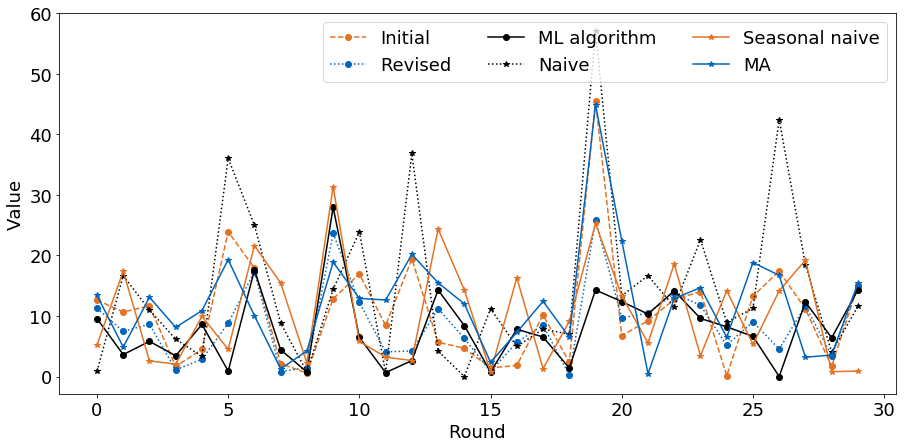

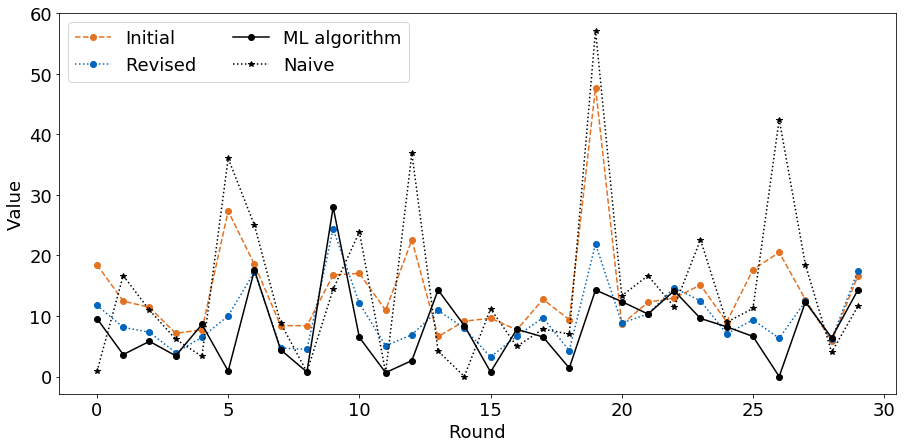

In [31]:
start = 0
end = 30
plot_all_6_mape(ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100,
               ape_fast(actuals[start:end], predict_naive_test_seasonal.iloc[228+start:228+start+end].values)*100, 
               ape_fast(actuals[start:end], predict_ma.iloc[1459+228+start:1459+228+start+end].values)*100,
               ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100,
               ape_fast(actuals[start:end], init_fcst_total.mean(0)[start:start+end].values)*100,
               ape_fast(actuals[start:end], rev_fcst_total.mean(0)[start:start+end].values)*100, 30)

plot_all_4_mape(100-init_ape_total[start:start+end].mean(0).values,
               100-rev_ape_total[start:start+end].mean(0).values,
               ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100,
               ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100, 30)

# uncomment so safe figure
#plt.savefig("4mape.eps", bbox_inches="tight")



In [39]:
# Participants MAPE

def print_all_mape(start = 0, end = 30):
    # Overall
    # Total
    print("========= Overall Total =========")
    overall_initial = 100 - init_ape_total.iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_total.iloc[:,start:end].mean().mean()
    print("Participants MAPE (forecasts %d:%d)        : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised, init_ape_total.mean().std(), rev_ape_total.mean().std()))

    # Control
    overall_initial = 100 - init_ape_ctrl.append(init_ape_ctrl_fb).iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_ctrl.append(rev_ape_ctrl_fb).iloc[:,start:end].mean().mean()
    print("Participants MAPE Control (forecasts %d:%d): Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_ctrl.append(init_ape_ctrl_fb).iloc[:,start:end].mean().std(),
           rev_ape_ctrl.append(rev_ape_ctrl_fb).iloc[:,start:end].mean().std()))
    # Treat
    overall_initial = 100 - init_ape_treat.append(init_ape_treat_fb).iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_treat.append(rev_ape_treat_fb).iloc[:,start:end].mean().mean()
    print("Participants MAPE Treat (forecasts %d:%d)  : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_treat.append(init_ape_treat_fb).iloc[:,start:end].mean().std(),
           rev_ape_treat.append(rev_ape_treat_fb).iloc[:,start:end].mean().std()))

    # Run 1
    # Total
    print("========= Run 1 Total =========")
    overall_initial = 100 - init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].mean().mean()
    print("Participants MAPE (forecasts %d:%d)        : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].mean().std(),
           rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].mean().std()))

    # Control
    overall_initial = 100 - init_ape_ctrl.iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_ctrl.iloc[:,start:end].mean().mean()
    print("Participants MAPE Control (forecasts %d:%d): Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_ctrl.iloc[:,start:end].mean().std(),
           rev_ape_ctrl.iloc[:,start:end].mean().std()))
    # Treat
    overall_initial = 100 - init_ape_treat.iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_treat.iloc[:,start:end].mean().mean()
    print("Participants MAPE Treat (forecasts %d:%d)  : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_treat.iloc[:,start:end].mean().std(),
           rev_ape_treat.iloc[:,start:end].mean().std()))


    # Run 2
    # Total
    print("========= Run 2 Total =========")
    #overall_initial = 100 - mape_initial_ctrl_fb.append(mape_initial_treat_fb).mean()
    overall_initial = 100 - init_ape_ctrl_fb.append(init_ape_treat_fb).iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_ctrl_fb.append(rev_ape_treat_fb).iloc[:,start:end].mean().mean()
    print("Participants MAPE (forecasts %d:%d)        : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_ctrl_fb.append(init_ape_treat_fb).iloc[:,start:end].mean().std(),
           rev_ape_ctrl_fb.append(rev_ape_treat_fb).iloc[:,start:end].mean().std()))

    # Control
    overall_initial = 100 - init_ape_ctrl_fb.iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_ctrl_fb.iloc[:,start:end].mean().mean()
    print("Participants MAPE Control (forecasts %d:%d): Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_ctrl_fb.iloc[:,start:end].mean().std(),
           rev_ape_ctrl_fb.iloc[:,start:end].mean().std()))
    # Treat
    overall_initial = 100 - init_ape_treat_fb.iloc[:,start:end].mean().mean()
    overall_revised = 100 - rev_ape_treat_fb.iloc[:,start:end].mean().mean()
    print("Participants MAPE Treat (forecasts %d:%d)  : Initial = %.2f; Revised = %.2f    SD: Initial = %.2f; Revised = %.2f "
          %(start, end, overall_initial, overall_revised,
           init_ape_treat_fb.iloc[:,start:end].mean().std(),
           rev_ape_treat_fb.iloc[:,start:end].mean().std()))

In [40]:
print_all_mape()

========= Overall Total =========
Participants MAPE (forecasts 0:30)        : Initial = 14.02; Revised = 9.74    SD: Initial = 7.97; Revised = 5.42 
Participants MAPE Control (forecasts 0:30): Initial = 14.26; Revised = 9.94    SD: Initial = 8.60; Revised = 5.48 
Participants MAPE Treat (forecasts 0:30)  : Initial = 13.80; Revised = 9.55    SD: Initial = 7.93; Revised = 5.43 
========= Run 1 Total =========
Participants MAPE (forecasts 0:30)        : Initial = 14.11; Revised = 9.76    SD: Initial = 8.46; Revised = 5.24 
Participants MAPE Control (forecasts 0:30): Initial = 14.96; Revised = 9.73    SD: Initial = 11.22; Revised = 5.46 
Participants MAPE Treat (forecasts 0:30)  : Initial = 13.41; Revised = 9.78    SD: Initial = 7.08; Revised = 5.16 
========= Run 2 Total =========
Participants MAPE (forecasts 0:30)        : Initial = 13.91; Revised = 9.71    SD: Initial = 7.82; Revised = 5.70 
Participants MAPE Control (forecasts 0:30): Initial = 13.56; Revised = 10.15    SD: Initial = 6.

In [42]:
### MAPE significances ###

# ML initial
print("ML <=> initial")
print("InitTotal: ",stats.mannwhitneyu(100-init_ape_total.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start]), alternative='two-sided'))
print("InitControl: ",stats.mannwhitneyu(100-init_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start]), alternative='two-sided'))
print("InitTreat: ",stats.mannwhitneyu(100-init_ape_treat.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start]), alternative='two-sided'))
print("InitControl_FB: ",stats.mannwhitneyu(100-init_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start]), alternative='two-sided'))
print("InitTreat_FB: ",stats.mannwhitneyu(100-init_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start]), alternative='two-sided'))

# Naive initial
print("\nNaive <=> initial")
print("InitTotal: ",stats.mannwhitneyu(100-init_ape_total.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100).reshape([end-start])
                                      , alternative='two-sided'))
print("InitControl: ",stats.mannwhitneyu(100-init_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100).reshape([end-start])
                                        , alternative='two-sided'))
print("InitTreat: ",stats.mannwhitneyu(100-init_ape_treat.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100).reshape([end-start])
                                      , alternative='two-sided'))
print("InitControl_FB: ",stats.mannwhitneyu(100-init_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100).reshape([end-start])
                                           , alternative='two-sided'))
print("InitTreat_FB: ",stats.mannwhitneyu(100-init_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], predict_naive_test.iloc[228+start:228+start+end].values)*100).reshape([end-start])
                                         , alternative='two-sided'))

# initial revised
print("\nRevised <=> initial")
print("Total: ",stats.wilcoxon(100-init_ape_total.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_total[start:start+end].mean(0).values))
print("Control: ",stats.wilcoxon(100-init_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_total[start:start+end].mean(0).values))
print("Treat: ",stats.wilcoxon(100-init_ape_treat.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_total[start:start+end].mean(0).values))
print("Control_FB: ",stats.wilcoxon(100-init_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_total[start:start+end].mean(0).values))
print("Treat_FB: ",stats.wilcoxon(100-init_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_total[start:start+end].mean(0).values))


# ML revised
print("\nRevised <=> ML")
print("InitTotal: ",stats.mannwhitneyu(100-rev_ape_total.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitControl: ",stats.mannwhitneyu(100-rev_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitTreat: ",stats.mannwhitneyu(100-rev_ape_treat.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitControl_FB: ",stats.mannwhitneyu(100-rev_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitTreat_FB: ",stats.mannwhitneyu(100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))

print("\nRevised <=> ML")
print("InitTotal: ",stats.wilcoxon(100-rev_ape_total.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitControl: ",stats.wilcoxon(100-rev_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitTreat: ",stats.wilcoxon(100-rev_ape_treat.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitControl_FB: ",stats.wilcoxon(100-rev_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))
print("InitTreat_FB: ",stats.wilcoxon(100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               (ape_fast(actuals[start:end], ml_forecasts[start:start+end])*100).reshape([end-start])))

ML <=> initial
InitTotal:  MannwhitneyuResult(statistic=681.0, pvalue=0.0006544102653646537)
InitControl:  MannwhitneyuResult(statistic=667.0, pvalue=0.001369486845372013)
InitTreat:  MannwhitneyuResult(statistic=674.0, pvalue=0.0009514505239359944)
InitControl_FB:  MannwhitneyuResult(statistic=680.0, pvalue=0.000690775986929919)
InitTreat_FB:  MannwhitneyuResult(statistic=678.0, pvalue=0.0007692077694162108)

Naive <=> initial
InitTotal:  MannwhitneyuResult(statistic=499.0, pvalue=0.47334041065774624)
InitControl:  MannwhitneyuResult(statistic=498.0, pvalue=0.48251082100519993)
InitTreat:  MannwhitneyuResult(statistic=488.0, pvalue=0.5792889403954998)
InitControl_FB:  MannwhitneyuResult(statistic=497.0, pvalue=0.49177694016861684)
InitTreat_FB:  MannwhitneyuResult(statistic=503.0, pvalue=0.4376349688978679)

Revised <=> initial
Total:  WilcoxonResult(statistic=41.0, pvalue=8.187753439649276e-05)
Control:  WilcoxonResult(statistic=48.0, pvalue=0.0001477276174888222)
Treat:  WilcoxonRes

In [43]:
### MAPE revised significances ###

# ML revised
print("\nRevised <=> ML")
print("revisedTotal: ",stats.mannwhitneyu(100-rev_ape_total.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values))
print("revisedControl: ",stats.mannwhitneyu(100-rev_ape_ctrl.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values))
print("revisedTreat: ",stats.mannwhitneyu(100-rev_ape_treat.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values))
print("revisedControl_FB: ",stats.mannwhitneyu(100-rev_ape_ctrl_fb.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values))
print("revisedTreat_FB: ",stats.mannwhitneyu(100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values, 
               100-rev_ape_treat_fb.iloc[:,start:start+end].mean(0).values))


Revised <=> ML
revisedTotal:  MannwhitneyuResult(statistic=414.0, pvalue=0.2998447422561852)
revisedControl:  MannwhitneyuResult(statistic=419.0, pvalue=0.32602181120031787)
revisedTreat:  MannwhitneyuResult(statistic=413.0, pvalue=0.2947255847028092)
revisedControl_FB:  MannwhitneyuResult(statistic=389.0, pvalue=0.1855385160632571)
revisedTreat_FB:  MannwhitneyuResult(statistic=450.0, pvalue=0.49704973080841425)


In [44]:
# positive adjustments

def pos_adjustment(df_init_ape, df_rev_ape):
    diff = -((df_init_ape.values)-(df_rev_ape.values))
    percent = np.sum(np.sum(diff > 0))/(df_init_ape.shape[0]*df_init_ape.shape[1])
    return diff, percent

# total
print("========= Overall Total =========")
diff_total, percent_total = pos_adjustment(init_ape_total, rev_ape_total)
diff_ctrl, percent_ctrl = pos_adjustment(init_ape_ctrl.append(init_ape_ctrl_fb), rev_ape_ctrl.append(rev_ape_ctrl_fb))
diff_treat, percent_treat = pos_adjustment(init_ape_treat.append(init_ape_treat_fb), rev_ape_treat.append(rev_ape_treat_fb))

print("Positive adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_total*100, percent_ctrl*100, percent_treat*100))

# round 1
print("========= Run 1 Total =========")
diff_r1_total, percent_r1_total = pos_adjustment(init_ape_ctrl.append(init_ape_treat), rev_ape_ctrl.append(rev_ape_treat))
diff_r1_ctrl, percent_r1_ctrl = pos_adjustment(init_ape_ctrl, rev_ape_ctrl)
diff_r1_treat, percent_r1_treat = pos_adjustment(init_ape_treat, rev_ape_treat)

print("Positive adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_r1_total*100, percent_r1_ctrl*100, percent_r1_treat*100))

# round 2
print("========= Run 2 Total =========")
diff_r2_total, percent_r2_total = pos_adjustment(init_ape_ctrl_fb.append(init_ape_treat_fb), rev_ape_ctrl_fb.append(rev_ape_treat_fb))
diff_r2_ctrl, percent_r2_ctrl = pos_adjustment(init_ape_ctrl_fb, rev_ape_ctrl_fb)
diff_r2_treat, percent_r2_treat = pos_adjustment(init_ape_treat_fb, rev_ape_treat_fb)

print("Positive adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_r2_total*100, percent_r2_ctrl*100, percent_r2_treat*100))



========= Overall Total =========
Positive adjustment percentage => Total:56.55; Control:55.25; Treat:57.73
========= Run 1 Total =========
Positive adjustment percentage => Total:55.83; Control:57.00; Treat:54.86
========= Run 2 Total =========
Positive adjustment percentage => Total:57.33; Control:53.50; Treat:61.17


In [45]:
# no adjustment

def no_adjustment(df_init, df_rev):
    df_return = df_init.copy()
    for i in range(df_init.shape[1]):
        df_return.iloc[:,i] = df_init.iloc[:,i] == df_rev.iloc[:,i]
    percent = df_return.values.sum()/(df_init.shape[0]*df_init.shape[1])
    return df_return, percent

# total
print("========= Overall Total =========")
diff_total_no, percent_total_no = no_adjustment(init_ape_total, rev_ape_total)
diff_ctrl_no, percent_ctrl_no = no_adjustment(init_ape_ctrl.append(init_ape_ctrl_fb), rev_ape_ctrl.append(rev_ape_ctrl_fb))
diff_treat_no, percent_treat_no = no_adjustment(init_ape_treat.append(init_ape_treat_fb), rev_ape_treat.append(rev_ape_treat_fb))

print("No adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_total_no*100, percent_ctrl_no*100, percent_treat_no*100))

# round 1
print("========= Run 1 Total =========")
diff_r1_total_no, percent_r1_total_no = no_adjustment(init_ape_ctrl.append(init_ape_treat), rev_ape_ctrl.append(rev_ape_treat))
diff_r1_ctrl_no, percent_r1_ctrl_no = no_adjustment(init_ape_ctrl, rev_ape_ctrl)
diff_r1_treat_no, percent_r1_treat_no = no_adjustment(init_ape_treat, rev_ape_treat)

print("No adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_r1_total_no*100, percent_r1_ctrl_no*100, percent_r1_treat_no*100))

# round 2
print("========= Run 2 Total =========")
diff_r2_total_no, percent_r2_total_no = no_adjustment(init_ape_ctrl_fb.append(init_ape_treat_fb), rev_ape_ctrl_fb.append(rev_ape_treat_fb))
diff_r2_ctrl_no, percent_r2_ctrl_no = no_adjustment(init_ape_ctrl_fb, rev_ape_ctrl_fb)
diff_r2_treat_no, percent_r2_treat_no = no_adjustment(init_ape_treat_fb, rev_ape_treat_fb)

print("No adjustment percentage => Total:%.2f; Control:%.2f; Treat:%.2f" %(percent_r2_total_no*100, percent_r2_ctrl_no*100, percent_r2_treat_no*100))




========= Overall Total =========
No adjustment percentage => Total:19.48; Control:22.00; Treat:17.20
========= Run 1 Total =========
No adjustment percentage => Total:19.39; Control:18.50; Treat:20.14
========= Run 2 Total =========
No adjustment percentage => Total:19.58; Control:25.50; Treat:13.67


In [46]:
# algorithm better than initial/revised
def better_than_alg(start=0, end=30):    
    # total 
    print("========= Overall Total =========")
    ml_better_total_init = sum(sum((ml_forecasts_ape.iloc[:,start:end].values > init_ape_total.iloc[:,start:end].values)))/(init_ape_total.iloc[:,start:end].shape[0]*init_ape_total.iloc[:,start:end].shape[1])
    ml_better_total_rev = sum(sum((ml_forecasts_ape.iloc[:,start:end].values > rev_ape_total.iloc[:,start:end].values)))/(rev_ape_total.iloc[:,start:end].shape[0]*rev_ape_total.iloc[:,start:end].shape[1])
    ml_better_ctrl_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_ctrl.append(init_ape_ctrl_fb))].iloc[:,start:end].values > init_ape_ctrl.append(init_ape_ctrl_fb).iloc[:,start:end].values)))/(init_ape_ctrl.append(init_ape_ctrl_fb).iloc[:,start:end].shape[0]*init_ape_ctrl.append(init_ape_ctrl_fb).iloc[:,start:end].shape[1])
    ml_better_ctrl_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_ctrl.append(rev_ape_ctrl_fb))].iloc[:,start:end].values > rev_ape_ctrl.append(rev_ape_ctrl_fb).iloc[:,start:end].values)))/(rev_ape_ctrl.append(rev_ape_ctrl_fb).iloc[:,start:end].shape[0]*rev_ape_ctrl.append(rev_ape_ctrl_fb).iloc[:,start:end].shape[1])
    ml_better_treat_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_treat.append(init_ape_treat_fb))].iloc[:,start:end].values > init_ape_treat.append(init_ape_treat_fb).iloc[:,start:end].values)))/(init_ape_treat.append(init_ape_treat_fb).iloc[:,start:end].shape[0]*init_ape_treat.append(init_ape_treat_fb).iloc[:,start:end].shape[1])
    ml_better_treat_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_treat.append(rev_ape_treat_fb))].iloc[:,start:end].values > rev_ape_treat.append(rev_ape_treat_fb).iloc[:,start:end].values)))/(rev_ape_treat.append(rev_ape_treat_fb).iloc[:,start:end].shape[0]*rev_ape_treat.append(rev_ape_treat_fb).iloc[:,start:end].shape[1])
    print("ML better percentage (%d:%d) => ...INIT... Total:%.2f; Control:%.2f; Treat:%.2f" %(start, end, ml_better_total_init*100, ml_better_ctrl_init*100, ml_better_treat_init*100))
    print("                            => ...REV...  Total:%.2f; Control:%.2f; Treat:%.2f" %(ml_better_total_rev*100, ml_better_ctrl_rev*100, ml_better_treat_rev*100))

    print("========= Run 1 Total =========")
    ml_better_r1_total_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_ctrl.append(init_ape_treat)),start:end].values > init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].values)))/(init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].shape[0]*init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].shape[1])
    ml_better_r1_total_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_ctrl.append(rev_ape_treat)),start:end].values > rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].values)))/(rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].shape[0]*rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].shape[1])
    ml_better_r1_ctrl_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_ctrl)].iloc[:,start:end].values > init_ape_ctrl.iloc[:,start:end].values)))/(init_ape_ctrl.iloc[:,start:end].shape[0]*init_ape_ctrl.iloc[:,start:end].shape[1])
    ml_better_r1_ctrl_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_ctrl)].iloc[:,start:end].values > rev_ape_ctrl.iloc[:,start:end].values)))/(rev_ape_ctrl.iloc[:,start:end].shape[0]*rev_ape_ctrl.iloc[:,start:end].shape[1])
    ml_better_r1_treat_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_treat)].iloc[:,start:end].values > init_ape_treat.iloc[:,start:end].values)))/(init_ape_treat.iloc[:,start:end].shape[0]*init_ape_treat.iloc[:,start:end].shape[1])
    ml_better_r1_treat_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_treat)].iloc[:,start:end].values > rev_ape_treat.iloc[:,start:end].values)))/(rev_ape_treat.iloc[:,start:end].shape[0]*rev_ape_treat.iloc[:,start:end].shape[1])
    print("ML better percentage (%d:%d) => ...INIT... Total:%.2f; Control:%.2f; Treat:%.2f" %(start, end, ml_better_r1_total_init*100, ml_better_r1_ctrl_init*100, ml_better_r1_treat_init*100))
    print("                            => ...REV...  Total:%.2f; Control:%.2f; Treat:%.2f" %(ml_better_r1_total_rev*100, ml_better_r1_ctrl_rev*100, ml_better_r1_treat_rev*100))

    print("========= Run 2 Total =========")
    ml_better_r2_total_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_ctrl_fb.append(init_ape_treat_fb)),start:end].values > init_ape_ctrl_fb.append(init_ape_treat_fb).iloc[:,start:end].values)))/(init_ape_ctrl_fb.append(init_ape_treat_fb).iloc[:,start:end].shape[0]*init_ape_ctrl.append(init_ape_treat).iloc[:,start:end].shape[1])
    ml_better_r2_total_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_ctrl_fb.append(rev_ape_treat_fb)),start:end].values > rev_ape_ctrl_fb.append(rev_ape_treat_fb).iloc[:,start:end].values)))/(rev_ape_ctrl_fb.append(rev_ape_treat_fb).iloc[:,start:end].shape[0]*rev_ape_ctrl.append(rev_ape_treat).iloc[:,start:end].shape[1])
    ml_better_r2_ctrl_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_ctrl_fb)].iloc[:,start:end].values > init_ape_ctrl_fb.iloc[:,start:end].values)))/(init_ape_ctrl_fb.iloc[:,start:end].shape[0]*init_ape_ctrl_fb.iloc[:,start:end].shape[1])
    ml_better_r2_ctrl_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_ctrl_fb)].iloc[:,start:end].values > rev_ape_ctrl_fb.iloc[:,start:end].values)))/(rev_ape_ctrl_fb.iloc[:,start:end].shape[0]*rev_ape_ctrl_fb.iloc[:,start:end].shape[1])
    ml_better_r2_treat_init = sum(sum((ml_forecasts_ape.iloc[:len(init_ape_treat_fb)].iloc[:,start:end].values > init_ape_treat_fb.iloc[:,start:end].values)))/(init_ape_treat_fb.iloc[:,start:end].shape[0]*init_ape_treat_fb.iloc[:,start:end].shape[1])
    ml_better_r2_treat_rev = sum(sum((ml_forecasts_ape.iloc[:len(rev_ape_treat_fb)].iloc[:,start:end].values > rev_ape_treat_fb.iloc[:,start:end].values)))/(rev_ape_treat_fb.iloc[:,start:end].shape[0]*rev_ape_treat_fb.iloc[:,start:end].shape[1])
    print("ML better percentage (%d:%d) => ...INIT... Total:%.2f; Control:%.2f; Treat:%.2f" %(start, end, ml_better_r2_total_init*100, ml_better_r2_ctrl_init*100, ml_better_r2_treat_init*100))
    print("                            => ...REV...  Total:%.2f; Control:%.2f; Treat:%.2f" %(ml_better_r2_total_rev*100, ml_better_r2_ctrl_rev*100, ml_better_r2_treat_rev*100))

print("=====================================")    
print("======== Algorithm is better ========")   
print("=====================================\n")
better_than_alg()     
print("------------------------------------------------------------------------------------------------------------")
better_than_alg(0,10) 
print("------------------------------------------------------------------------------------------------------------")
better_than_alg(10,20) 
print("------------------------------------------------------------------------------------------------------------")
better_than_alg(20,30) 
print("------------------------------------------------------------------------------------------------------------")
better_than_alg(0,1)   
print("------------------------------------------------------------------------------------------------------------")
better_than_alg(1,2) 

======== Algorithm is better ========

========= Overall Total =========
ML better percentage (0:30) => ...INIT... Total:63.69; Control:62.67; Treat:64.62
                            => ...REV...  Total:50.75; Control:52.50; Treat:49.17
========= Run 1 Total =========
ML better percentage (0:30) => ...INIT... Total:62.73; Control:62.83; Treat:62.64
                            => ...REV...  Total:52.73; Control:52.17; Treat:53.19
========= Run 2 Total =========
ML better percentage (0:30) => ...INIT... Total:64.75; Control:62.50; Treat:67.00
                            => ...REV...  Total:48.58; Control:52.83; Treat:44.33
------------------------------------------------------------------------------------------------------------
========= Overall Total =========
ML better percentage (0:10) => ...INIT... Total:60.60; Control:59.75; Treat:61.36
                            => ...REV...  Total:47.50; Control:48.75; Treat:46.36
========= Run 1 Total =========
ML better percentage (0:10) => .

In [48]:
### calculate WOA*s ###
dist_percentage_total = apply_winzor(go_with_algorithm(init_fcst_total, rev_fcst_total, ml_forecasts))
dist_percentage_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_ctrl_fb), rev_fcst_ctrl.append(rev_fcst_ctrl_fb), ml_forecasts))
dist_percentage_treat = apply_winzor(go_with_algorithm(init_fcst_treat.append(init_fcst_treat_fb), rev_fcst_treat.append(rev_fcst_treat_fb), ml_forecasts))
    

# run 1 
print("========= Run 1 Total =========")
dist_percentage_r1_total = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_treat), rev_fcst_ctrl.append(rev_fcst_treat), ml_forecasts))
dist_percentage_r1_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl, rev_fcst_ctrl, ml_forecasts))
dist_percentage_r1_treat = apply_winzor(go_with_algorithm(init_fcst_treat, rev_fcst_treat, ml_forecasts))
    
    
# run 2 
print("========= Run 2 Total =========")
dist_percentage_r2_total = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb.append(init_fcst_treat_fb), rev_fcst_ctrl_fb.append(rev_fcst_treat_fb), ml_forecasts))
dist_percentage_r2_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb, rev_fcst_ctrl_fb, ml_forecasts))
dist_percentage_r2_treat = apply_winzor(go_with_algorithm(init_fcst_treat_fb, rev_fcst_treat_fb, ml_forecasts))


========= Run 1 Total =========
========= Run 2 Total =========


C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



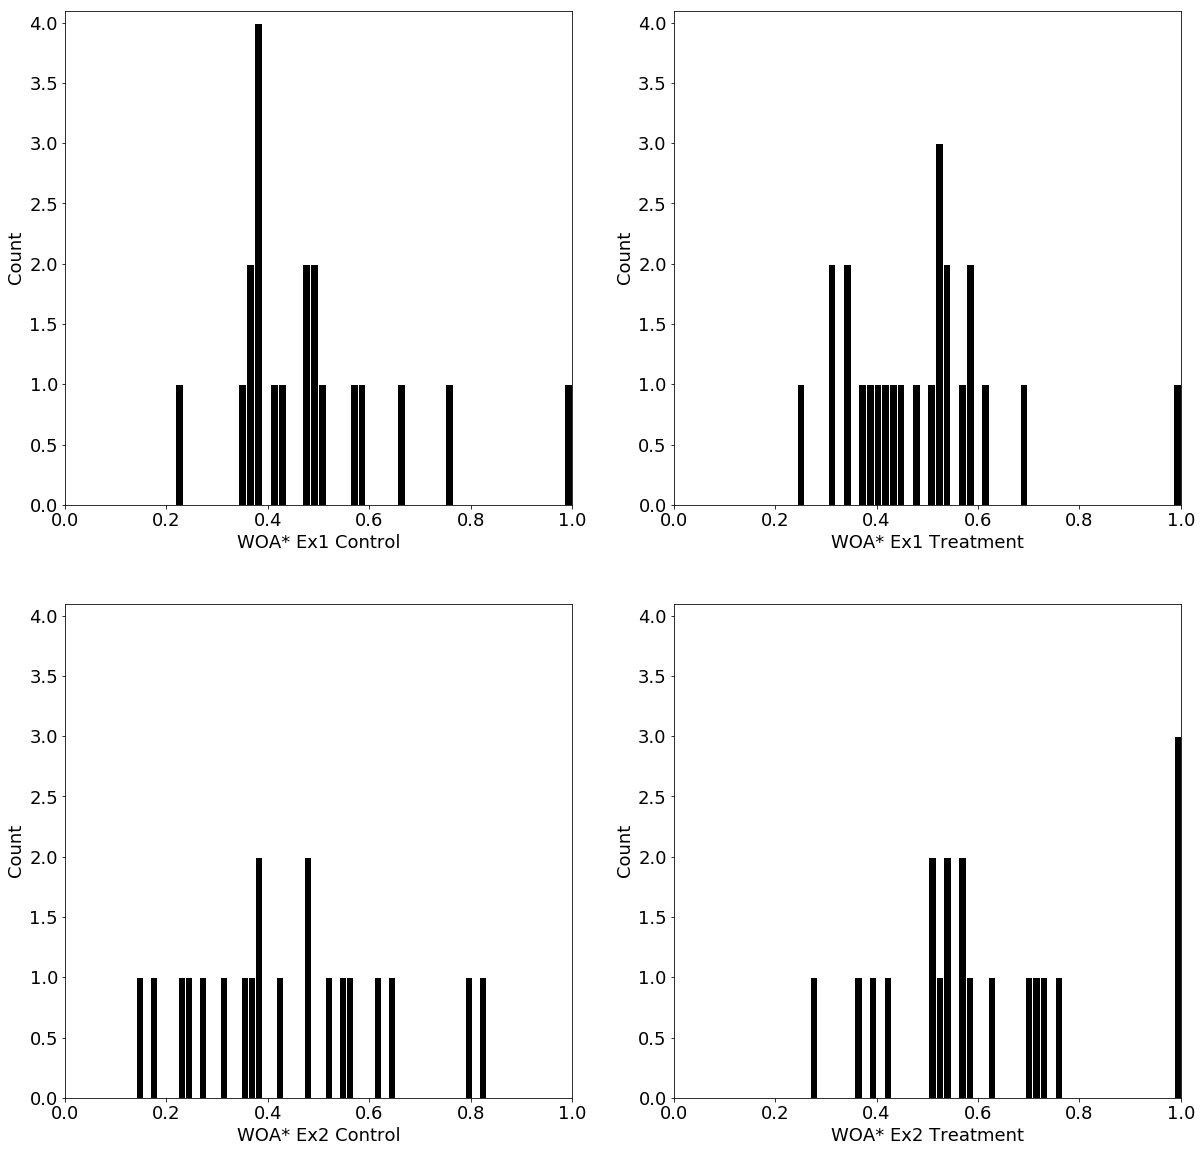

In [49]:
### WOA* distributions histogram ###
fig, axes = plt.subplots(2,2, figsize=(20,20)) # create figure and axes
binsize = 2
    # total
    
    # seaborn histogram
    
    
#axes[0,0].set_title('Histogram - 1st experiment control (forecasts:' + str(start) +'-' + str(end) + ')')
sns.distplot(dist_percentage_r1_ctrl.mean(1),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = '#000000',
                 hist_kws={'edgecolor':'white', "alpha": 1}, ax=axes[0,0], axlabel='WOA* Ex1 Control') 
sns.distplot(dist_percentage_r1_treat.mean(1),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = '#000000',
                 hist_kws={'edgecolor':'white', "alpha": 1}, ax=axes[0,1], axlabel='WOA* Ex1 Treatment')
sns.distplot(dist_percentage_r2_ctrl.mean(1),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = '#000000',
                 hist_kws={'edgecolor':'white', "alpha": 1}, ax=axes[1,0], axlabel='WOA* Ex2 Control') 
sns.distplot(dist_percentage_r2_treat.mean(1),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = '#000000',
                 hist_kws={'edgecolor':'white', "alpha": 1}, ax=axes[1,1], axlabel='WOA* Ex2 Treatment')
axes[0,0].set_ylim([0,4.1])
axes[0,1].set_ylim([0,4.1])
axes[1,0].set_ylim([0,4.1])
axes[1,1].set_ylim([0,4.1])
axes[0,0].set_xlim([0,1])
axes[0,1].set_xlim([0,1])
axes[1,0].set_xlim([0,1])
axes[1,1].set_xlim([0,1])
axes[0,0].set_ylabel("Count")
axes[0,1].set_ylabel("Count")
axes[1,0].set_ylabel("Count")
axes[1,1].set_ylabel("Count")

plt.rcParams.update({'font.size': 20})
# uncomment so safe figure
#plt.savefig("woaDist.pdf", bbox_inches="tight",pad_inches=0)

In [50]:
### effect sizes ###

from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = mean(d1), mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [51]:
### difference effects - cohens d ###
cohen = cohend(ml_forecasts_ape.iloc[0,:].values, init_ape_total.mean().values)
cohen

0.8432930099964788

In [52]:
### effect size for WOA ###
cohen_woa = cohend(dist_percentage_r2_ctrl.mean(1), dist_percentage_r2_treat.mean(1))
cohen_woa

-0.9004833402574902

In [53]:
### correlations effects - pearsons r ###
print(stats.pearsonr(ml_forecasts_ape.iloc[0,:].values, init_ape_total.mean().values))

(0.23651495301933212, 0.20826696275574608)


========= Overall Total =========
========= Run 1 Total =========
========= Run 2 Total =========


C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.

C:\Inicio\tools\64\Anaconda3-5.2.0.1\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarni

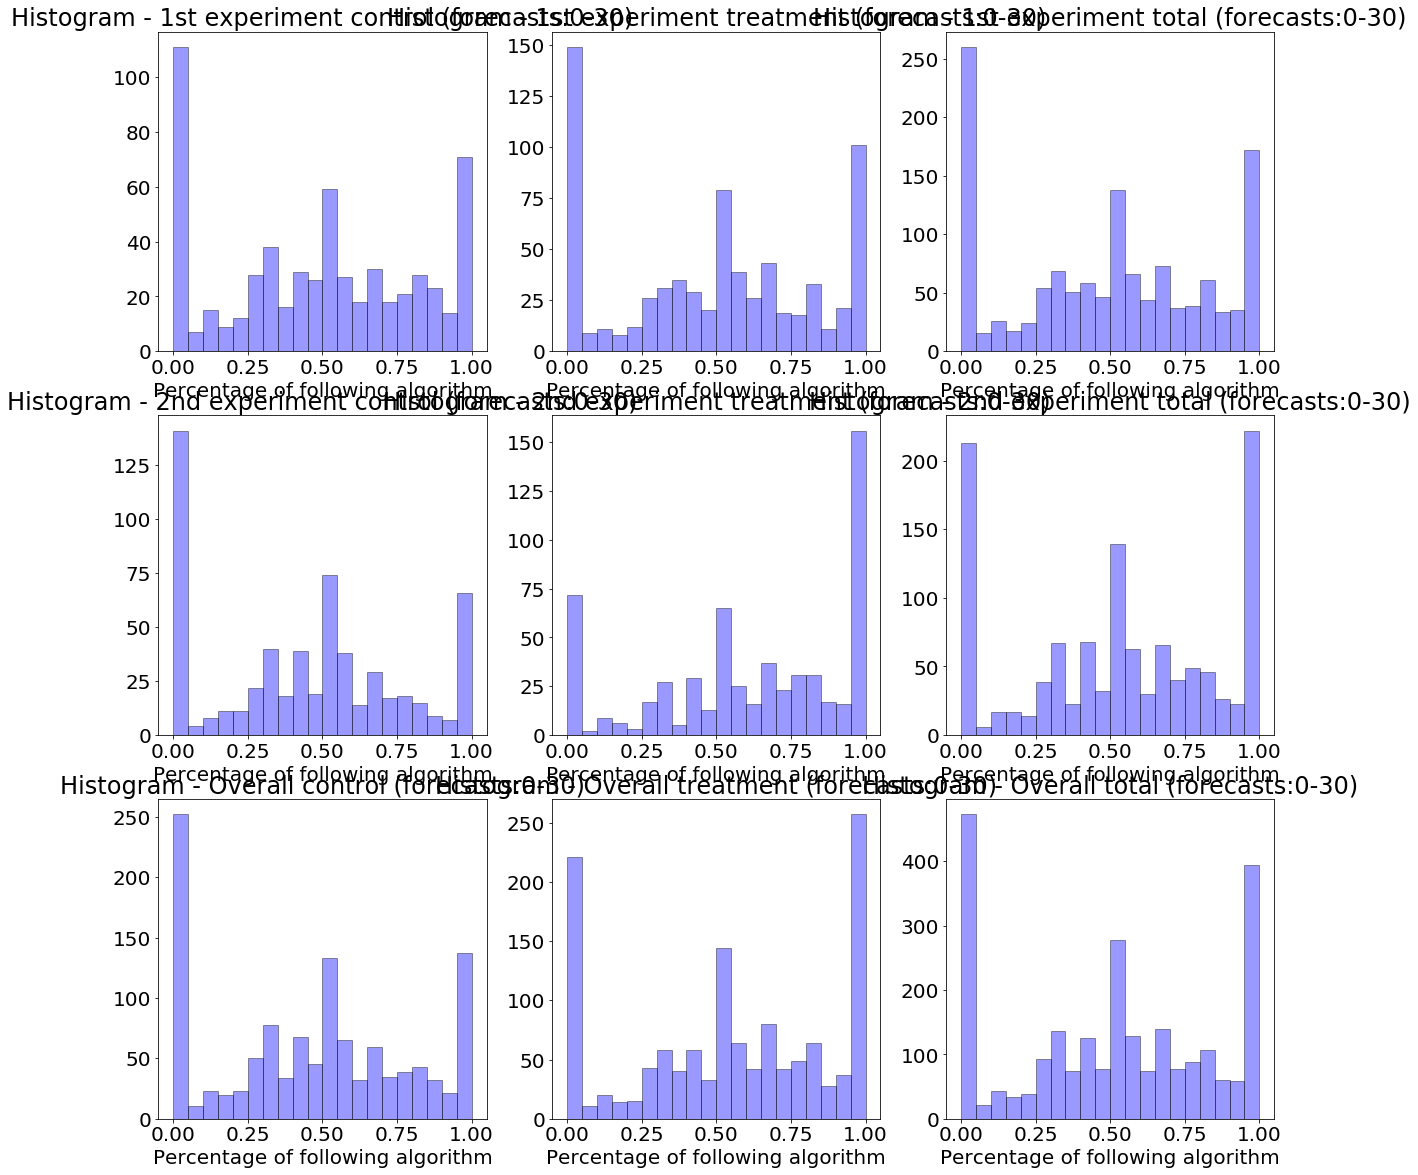

In [54]:
def visualizeHist_follow_algorithm_noAvg(start=0, end=30, binsize=5):
    # total 
    print("========= Overall Total =========")
    dist_percentage_total = apply_winzor(go_with_algorithm(init_fcst_total, rev_fcst_total, ml_forecasts))
    dist_percentage_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_ctrl_fb), rev_fcst_ctrl.append(rev_fcst_ctrl_fb), ml_forecasts))
    dist_percentage_treat = apply_winzor(go_with_algorithm(init_fcst_treat.append(init_fcst_treat_fb), rev_fcst_treat.append(rev_fcst_treat_fb), ml_forecasts))
    

    # run 1 
    print("========= Run 1 Total =========")
    dist_percentage_r1_total = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_treat), rev_fcst_ctrl.append(rev_fcst_treat), ml_forecasts))
    dist_percentage_r1_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl, rev_fcst_ctrl, ml_forecasts))
    dist_percentage_r1_treat = apply_winzor(go_with_algorithm(init_fcst_treat, rev_fcst_treat, ml_forecasts))
    
    
    # run 2 
    print("========= Run 2 Total =========")
    dist_percentage_r2_total = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb.append(init_fcst_treat_fb), rev_fcst_ctrl_fb.append(rev_fcst_treat_fb), ml_forecasts))
    dist_percentage_r2_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb, rev_fcst_ctrl_fb, ml_forecasts))
    dist_percentage_r2_treat = apply_winzor(go_with_algorithm(init_fcst_treat_fb, rev_fcst_treat_fb, ml_forecasts))
    
    fig, axes = plt.subplots(3,3, figsize=(20,20)) # create figure and axes

    # total
    
    # seaborn histogram
    
    
    axes[0,0].set_title('Histogram - 1st experiment control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_ctrl[:,start:end].reshape(dist_percentage_r1_ctrl[:,start:end].shape[0]*dist_percentage_r1_ctrl[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[0,0], axlabel='Percentage of following algorithm')    
    
    
    axes[0,1].set_title('Histogram - 1st experiment treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_treat[:,start:end].reshape(dist_percentage_r1_treat[:,start:end].shape[0]*dist_percentage_r1_treat[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[0,1], axlabel='Percentage of following algorithm')

    
    axes[0,2].set_title('Histogram - 1st experiment total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_total[:,start:end].reshape(dist_percentage_r1_total[:,start:end].shape[0]*dist_percentage_r1_total[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[0,2], axlabel='Percentage of following algorithm')  

    
    axes[1,0].set_title('Histogram - 2nd experiment control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_ctrl[:,start:end].reshape(dist_percentage_r2_ctrl[:,start:end].shape[0]*dist_percentage_r2_ctrl[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[1,0], axlabel='Percentage of following algorithm')  
    
    axes[1,1].set_title('Histogram - 2nd experiment treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_treat[:,start:end].reshape(dist_percentage_r2_treat[:,start:end].shape[0]*dist_percentage_r2_treat[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[1,1], axlabel='Percentage of following algorithm') 
    
    axes[1,2].set_title('Histogram - 2nd experiment total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_total[:,start:end].reshape(dist_percentage_r2_total[:,start:end].shape[0]*dist_percentage_r2_total[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[1,2], axlabel='Percentage of following algorithm') 
    
    axes[2,0].set_title('Histogram - Overall control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_ctrl[:,start:end].reshape(dist_percentage_ctrl[:,start:end].shape[0]*dist_percentage_ctrl[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[2,0], axlabel='Percentage of following algorithm')  
    
    axes[2,1].set_title('Histogram - Overall treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_treat[:,start:end].reshape(dist_percentage_treat[:,start:end].shape[0]*dist_percentage_treat[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[2,1], axlabel='Percentage of following algorithm') 
    
    axes[2,2].set_title('Histogram - Overall total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_total[:,start:end].reshape(dist_percentage_total[:,start:end].shape[0]*dist_percentage_total[:,start:end].shape[1]),
                 hist=True, kde=False, 
                 bins=int(100/binsize), color = 'blue',
                 hist_kws={'edgecolor':'black'}, ax=axes[2,2], axlabel='Percentage of following algorithm')

    # uncommment to safe figure
    #fig.savefig('histograms_noAvg.pdf')
    
visualizeHist_follow_algorithm_noAvg(0,30,5)

In [55]:
def visualizeHist_follow_algorithm(start=0, end=30, binsize=5):
    # total 
    print("========= Overall Total =========")
    dist_percentage_total = apply_winzor(go_with_algorithm(init_fcst_total, rev_fcst_total, ml_forecasts))
    dist_percentage_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_ctrl_fb), rev_fcst_ctrl.append(rev_fcst_ctrl_fb), ml_forecasts))
    dist_percentage_treat = apply_winzor(go_with_algorithm(init_fcst_treat.append(init_fcst_treat_fb), rev_fcst_treat.append(rev_fcst_treat_fb), ml_forecasts))
    

    # run 1 
    print("========= Run 1 Total =========")
    dist_percentage_r1_total = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_treat), rev_fcst_ctrl.append(rev_fcst_treat), ml_forecasts))
    dist_percentage_r1_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl, rev_fcst_ctrl, ml_forecasts))
    dist_percentage_r1_treat = apply_winzor(go_with_algorithm(init_fcst_treat, rev_fcst_treat, ml_forecasts))
    
    
    # run 2 
    print("========= Run 2 Total =========")
    dist_percentage_r2_total = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb.append(init_fcst_treat_fb), rev_fcst_ctrl_fb.append(rev_fcst_treat_fb), ml_forecasts))
    dist_percentage_r2_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb, rev_fcst_ctrl_fb, ml_forecasts))
    dist_percentage_r2_treat = apply_winzor(go_with_algorithm(init_fcst_treat_fb, rev_fcst_treat_fb, ml_forecasts))
    
    fig, axes = plt.subplots(3,3, figsize=(20,20)) # create figure and axes

    # total
    
    # seaborn histogram
    
    
    axes[0,0].set_title('Histogram - 1st experiment control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_ctrl[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0,0], axlabel='Percentage of following algorithm')    
    
    
    axes[0,1].set_title('Histogram - 1st experiment treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_treat[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0,1], axlabel='Percentage of following algorithm')

    
    axes[0,2].set_title('Histogram - 1st experiment total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r1_total[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[0,2], axlabel='Percentage of following algorithm')  

    
    axes[1,0].set_title('Histogram - 2nd experiment control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_ctrl[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[1,0], axlabel='Percentage of following algorithm')  
    
    axes[1,1].set_title('Histogram - 2nd experiment treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_treat[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[1,1], axlabel='Percentage of following algorithm') 
    
    axes[1,2].set_title('Histogram - 2nd experiment total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_r2_total[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[1,2], axlabel='Percentage of following algorithm') 
    
    axes[2,0].set_title('Histogram - Overall control (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_ctrl[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[2,0], axlabel='Percentage of following algorithm')  
    
    axes[2,1].set_title('Histogram - Overall treatment (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_treat[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[2,1], axlabel='Percentage of following algorithm') 
    
    axes[2,2].set_title('Histogram - Overall total (forecasts:' + str(start) +'-' + str(end) + ')')
    sns.distplot(dist_percentage_total[:,start:end].mean(axis=1), hist=True, kde=False, 
             bins=int(100/binsize), color = 'blue',
             hist_kws={'edgecolor':'black'}, ax=axes[2,2], axlabel='Percentage of following algorithm')

    
    fig.savefig('histograms.pdf')
    
# average over participants
def visualizeBox_follow_algorithm(start=0, end=30):
    # total 
    print("========= Overall Total =========")
    dist_percentage_total = apply_winzor(go_with_algorithm(init_fcst_total, rev_fcst_total, ml_forecasts))
    dist_percentage_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_ctrl_fb), rev_fcst_ctrl.append(rev_fcst_ctrl_fb), ml_forecasts))
    dist_percentage_treat = apply_winzor(go_with_algorithm(init_fcst_treat.append(init_fcst_treat_fb), rev_fcst_treat.append(rev_fcst_treat_fb), ml_forecasts))
    

    # run 1 
    print("========= Run 1 Total =========")
    dist_percentage_r1_total = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_treat), rev_fcst_ctrl.append(rev_fcst_treat), ml_forecasts))
    dist_percentage_r1_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl, rev_fcst_ctrl, ml_forecasts))
    dist_percentage_r1_treat = apply_winzor(go_with_algorithm(init_fcst_treat, rev_fcst_treat, ml_forecasts))
    
    
    # run 2 
    print("========= Run 2 Total =========")
    dist_percentage_r2_total = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb.append(init_fcst_treat_fb), rev_fcst_ctrl_fb.append(rev_fcst_treat_fb), ml_forecasts))
    dist_percentage_r2_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb, rev_fcst_ctrl_fb, ml_forecasts))
    dist_percentage_r2_treat = apply_winzor(go_with_algorithm(init_fcst_treat_fb, rev_fcst_treat_fb, ml_forecasts))
    
    fig, axes = plt.subplots(3,1, figsize=(20,20)) # create figure and axes

    # total
    
    axes[0].set_title('1st experiment (forecasts:' + str(start) +'-' + str(end) + ')')
    axes[0].boxplot([dist_percentage_r1_ctrl[:,start:end].mean(axis=1), 
                     dist_percentage_r1_treat[:,start:end].mean(axis=1),
                     dist_percentage_r1_total[:,start:end].mean(axis=1)], labels=["Control", "Treatment","Total"])
    axes[1].set_title('2nd experiment (forecasts:' + str(start) +'-' + str(end) + ')')
    axes[1].boxplot([dist_percentage_r2_ctrl[:,start:end].mean(axis=1), 
                     dist_percentage_r2_treat[:,start:end].mean(axis=1),
                     dist_percentage_r2_total[:,start:end].mean(axis=1)], labels=["Control", "Treatment","Total"])
    axes[2].set_title('Overall (forecasts:' + str(start) +'-' + str(end) + ')')
    axes[2].boxplot([dist_percentage_ctrl[:,start:end].mean(axis=1), 
                     dist_percentage_treat[:,start:end].mean(axis=1), 
                     dist_percentage_total[:,start:end].mean(axis=1)], labels=["Control", "Treatment","Total"])
    
    fig.savefig("followAlgorithBoxplot_fcst" + str(start) +'_' + str(end) + '.pdf')
    

def print_follow_algorithm(start=0, end=30):
    # total 
    print("========= Overall Total =========")
    dist_percentage_total = apply_winzor(go_with_algorithm(init_fcst_total, rev_fcst_total, ml_forecasts))
    dist_percentage_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_ctrl_fb), rev_fcst_ctrl.append(rev_fcst_ctrl_fb), ml_forecasts))
    dist_percentage_treat = apply_winzor(go_with_algorithm(init_fcst_treat.append(init_fcst_treat_fb), rev_fcst_treat.append(rev_fcst_treat_fb), ml_forecasts))
    print("Follow algorithm percentage (%d:%d)(mean|std) => Total:(%.2f|%.2f); Control:(%.2f|%.2f); Treat:(%.2f|%.2f)" 
          %(start+1, end, dist_percentage_total[:,start:end].mean()*100, dist_percentage_total[:,start:end].mean(axis=1).std()*100,
            dist_percentage_ctrl[:,start:end].mean()*100, dist_percentage_ctrl[:,start:end].mean(axis=1).std()*100,
            dist_percentage_treat[:,start:end].mean()*100, dist_percentage_treat[:,start:end].mean(axis=1).std()*100))


    # run 1 
    print("========= Run 1 Total =========")
    dist_percentage_r1_total = apply_winzor(go_with_algorithm(init_fcst_ctrl.append(init_fcst_treat), rev_fcst_ctrl.append(rev_fcst_treat), ml_forecasts))
    dist_percentage_r1_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl, rev_fcst_ctrl, ml_forecasts))
    dist_percentage_r1_treat = apply_winzor(go_with_algorithm(init_fcst_treat, rev_fcst_treat, ml_forecasts))
    print("Follow algorithm percentage (%d:%d)(mean|std) => Total:(%.2f|%.2f); Control:(%.2f|%.2f); Treat:(%.2f|%.2f)" 
          %(start+1, end, dist_percentage_r1_total[:,start:end].mean(), dist_percentage_r1_total[:,start:end].mean(axis=1).std(),
            dist_percentage_r1_ctrl[:,start:end].mean(), dist_percentage_r1_ctrl[:,start:end].mean(axis=1).std(), 
            dist_percentage_r1_treat[:,start:end].mean(), dist_percentage_r1_treat[:,start:end].mean(axis=1).std()))


    # run 2 
    print("========= Run 2 Total =========")
    dist_percentage_r2_total = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb.append(init_fcst_treat_fb), rev_fcst_ctrl_fb.append(rev_fcst_treat_fb), ml_forecasts))
    dist_percentage_r2_ctrl = apply_winzor(go_with_algorithm(init_fcst_ctrl_fb, rev_fcst_ctrl_fb, ml_forecasts))
    dist_percentage_r2_treat = apply_winzor(go_with_algorithm(init_fcst_treat_fb, rev_fcst_treat_fb, ml_forecasts))
    print("Follow algorithm percentage (%d:%d)(mean|std) => Total:(%.2f|%.2f); Control:(%.2f|%.2f); Treat:(%.2f|%.2f)"
          %(start+1, end, dist_percentage_r2_total[:,start:end].mean()*100, dist_percentage_r2_total[:,start:end].mean(axis=1).std()*100,
            dist_percentage_r2_ctrl[:,start:end].mean()*100, dist_percentage_r2_ctrl[:,start:end].mean(axis=1).std()*100,
            dist_percentage_r2_treat[:,start:end].mean()*100, dist_percentage_r2_treat[:,start:end].mean(axis=1).std()*100))

print("==================================")    
print("======== Follow algorithm ========")   
print("==================================\n")
print_follow_algorithm(1,30)     
print("------------------------------------------------------------------------------------------------------------")
print_follow_algorithm(1,11) 
print("------------------------------------------------------------------------------------------------------------")
print_follow_algorithm(11,21) 
print("------------------------------------------------------------------------------------------------------------")
print_follow_algorithm(21,30) 
print("------------------------------------------------------------------------------------------------------------")
print_follow_algorithm(0,1)
print("------------------------------------------------------------------------------------------------------------")
print_follow_algorithm(1,2) 





======== Follow algorithm ========

========= Overall Total =========
Follow algorithm percentage (2:30)(mean|std) => Total:(50.41|18.92); Control:(45.92|17.94); Treat:(54.49|18.87)
========= Run 1 Total =========
Follow algorithm percentage (2:30)(mean|std) => Total:(0.48|0.16); Control:(0.48|0.17); Treat:(0.48|0.15)
========= Run 2 Total =========
Follow algorithm percentage (2:30)(mean|std) => Total:(52.65|21.40); Control:(43.52|18.67); Treat:(61.78|20.02)
------------------------------------------------------------------------------------------------------------
========= Overall Total =========
Follow algorithm percentage (2:11)(mean|std) => Total:(50.47|19.18); Control:(45.30|17.65); Treat:(55.17|19.31)
========= Run 1 Total =========
Follow algorithm percentage (2:11)(mean|std) => Total:(0.47|0.15); Control:(0.47|0.16); Treat:(0.47|0.14)
========= Run 2 Total =========
Follow algorithm percentage (2:11)(mean|std) => Total:(54.10|22.34); Control:(43.30|18.52); Treat:(64.90|20.54)

In [57]:
### WOA*s of "old" participants ###

print("### age 56-57 ###")
print(dist_percentage_total[64].mean())
print("### age 38-39 ###")
print(dist_percentage_total[62].mean())
print("### age 34-35###")
print(dist_percentage_total[42].mean())
print("### age 30-31 ###")
print(dist_percentage_total[43].mean())
print(dist_percentage_total[63].mean())
print(dist_percentage_total[76].mean())


### age 56-57 ###
0.3848641640832311
### age 38-39 ###
0.4240313343061833
### age 34-35###
0.24272241058665417
### age 30-31 ###
0.5694767380448998
0.5695724861940573
0.5709097378142267


In [58]:
### feedback effects within group (2nd experiment) ###

print(stats.wilcoxon(dist_percentage_r2_treat[:,1:10].mean(1), dist_percentage_r2_treat[:,11:20].mean(1)))
print(stats.wilcoxon(dist_percentage_r2_treat[:,1:10].mean(1), dist_percentage_r2_treat[:,21:30].mean(1)))
print(stats.wilcoxon(dist_percentage_r2_treat[:,11:20].mean(1), dist_percentage_r2_treat[:,21:30].mean(1)))

print(stats.wilcoxon(dist_percentage_r1_treat[:,1:10].mean(1), dist_percentage_r1_treat[:,11:20].mean(1)))
print(stats.wilcoxon(dist_percentage_r1_treat[:,1:10].mean(1), dist_percentage_r1_treat[:,21:30].mean(1)))
print(stats.wilcoxon(dist_percentage_r1_treat[:,11:20].mean(1), dist_percentage_r1_treat[:,21:30].mean(1)))

print(stats.wilcoxon(dist_percentage_r2_ctrl[:,1:10].mean(1), dist_percentage_r2_ctrl[:,11:20].mean(1)))
print(stats.wilcoxon(dist_percentage_r2_ctrl[:,1:10].mean(1), dist_percentage_r2_ctrl[:,21:30].mean(1)))
print(stats.wilcoxon(dist_percentage_r2_ctrl[:,11:20].mean(1), dist_percentage_r2_ctrl[:,21:30].mean(1)))

print(stats.wilcoxon(dist_percentage_r1_ctrl[:,1:10].mean(1), dist_percentage_r1_ctrl[:,11:20].mean(1)))
print(stats.wilcoxon(dist_percentage_r1_ctrl[:,1:10].mean(1), dist_percentage_r1_ctrl[:,21:30].mean(1)))
print(stats.wilcoxon(dist_percentage_r1_ctrl[:,11:20].mean(1), dist_percentage_r1_ctrl[:,21:30].mean(1)))

WilcoxonResult(statistic=43.0, pvalue=0.11277865463569872)
WilcoxonResult(statistic=44.0, pvalue=0.12392922503869737)
WilcoxonResult(statistic=63.0, pvalue=0.5227810104666994)
WilcoxonResult(statistic=138.0, pvalue=1.0)
WilcoxonResult(statistic=120.0, pvalue=0.584056453701191)
WilcoxonResult(statistic=132.0, pvalue=0.8551984216262508)
WilcoxonResult(statistic=80.0, pvalue=0.3506564539028397)
WilcoxonResult(statistic=100.0, pvalue=0.8519245948146423)
WilcoxonResult(statistic=74.0, pvalue=0.2471446025403431)
WilcoxonResult(statistic=63.0, pvalue=0.19783306556714142)
WilcoxonResult(statistic=42.0, pvalue=0.03293821172843571)
WilcoxonResult(statistic=40.0, pvalue=0.02687559167118386)


========= Overall Total =========
========= Run 1 Total =========
========= Run 2 Total =========
========= Overall Total =========
========= Run 1 Total =========
========= Run 2 Total =========
========= Overall Total =========
========= Run 1 Total =========
========= Run 2 Total =========
========= Overall Total =========
========= Run 1 Total =========
========= Run 2 Total =========


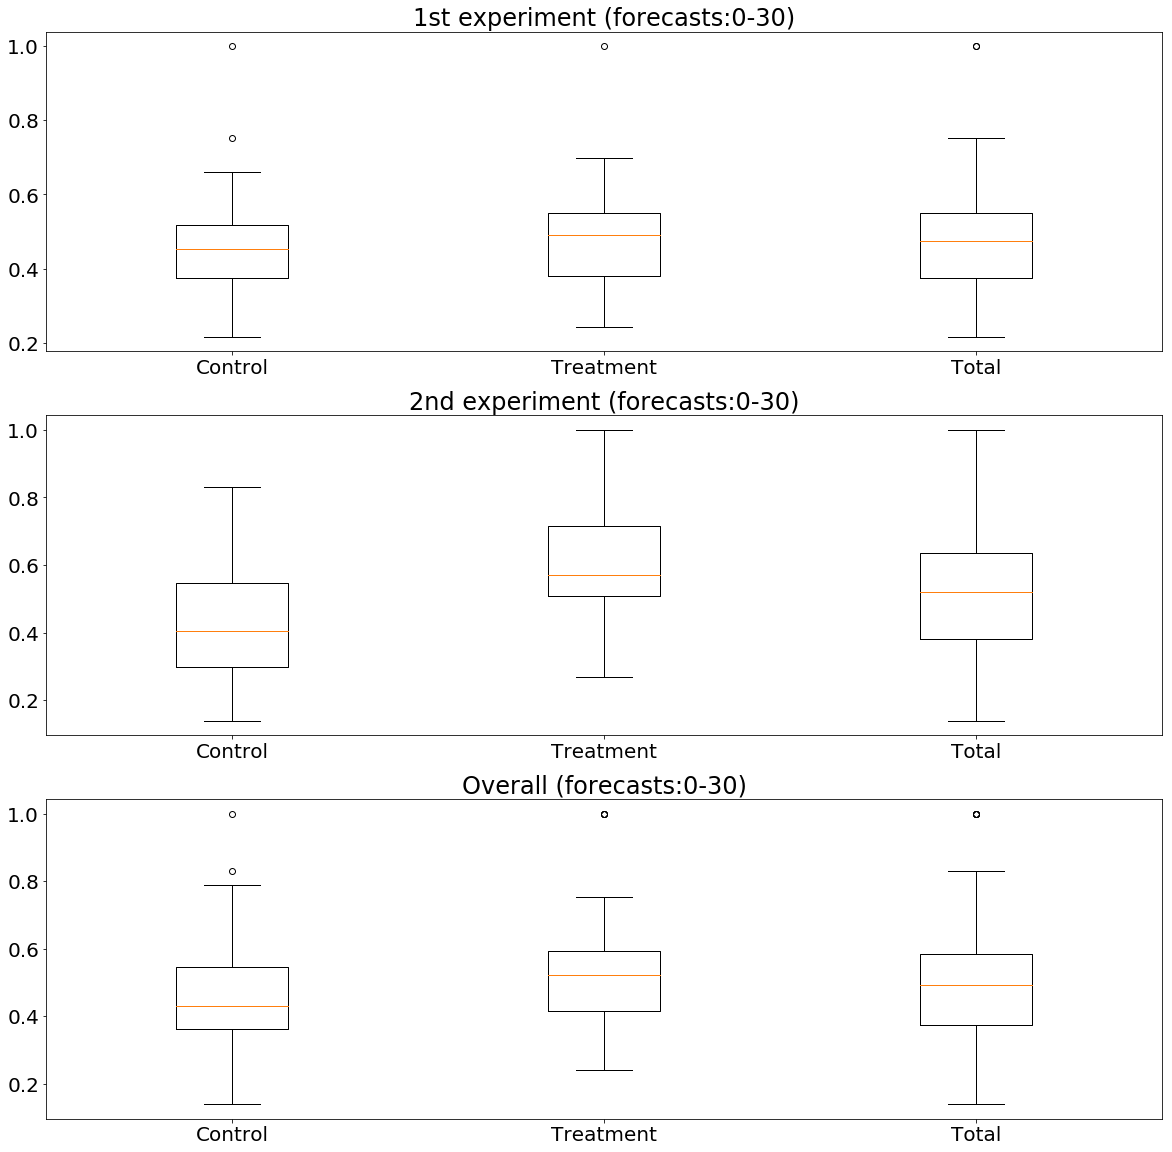

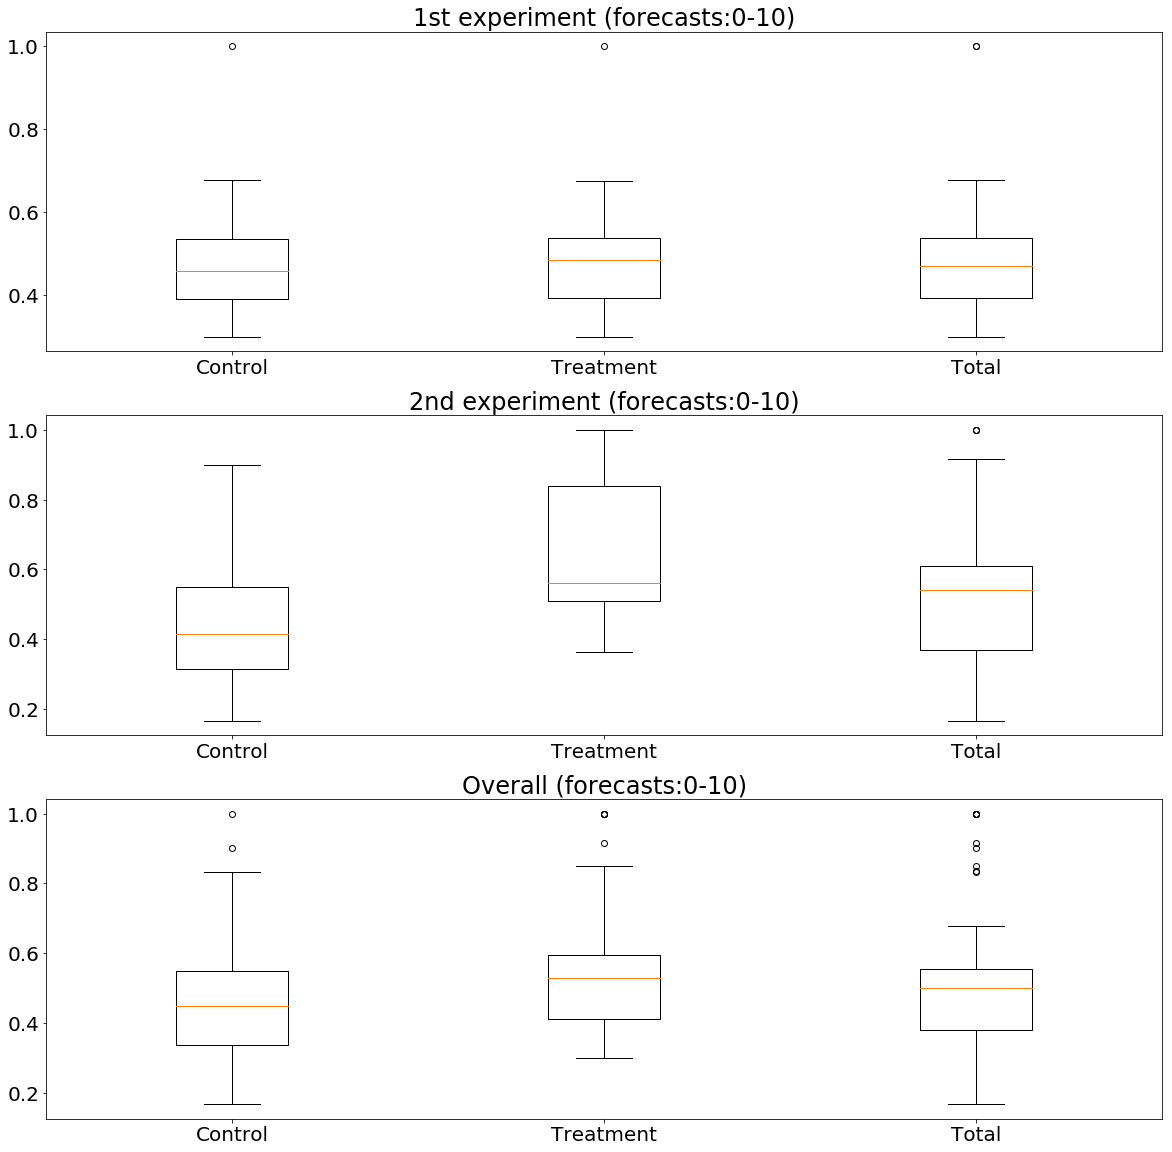

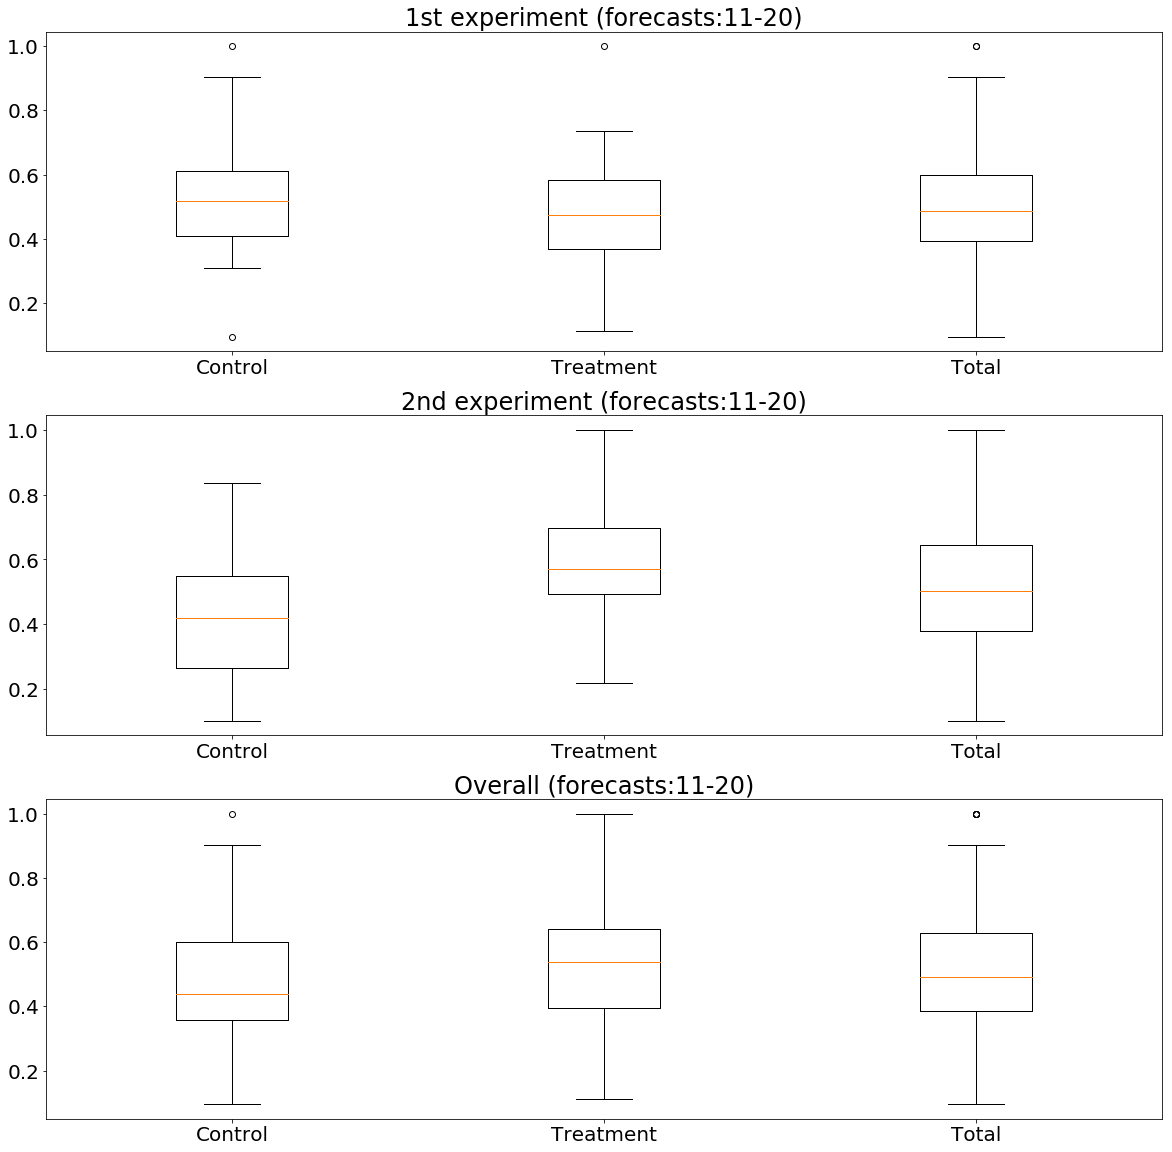

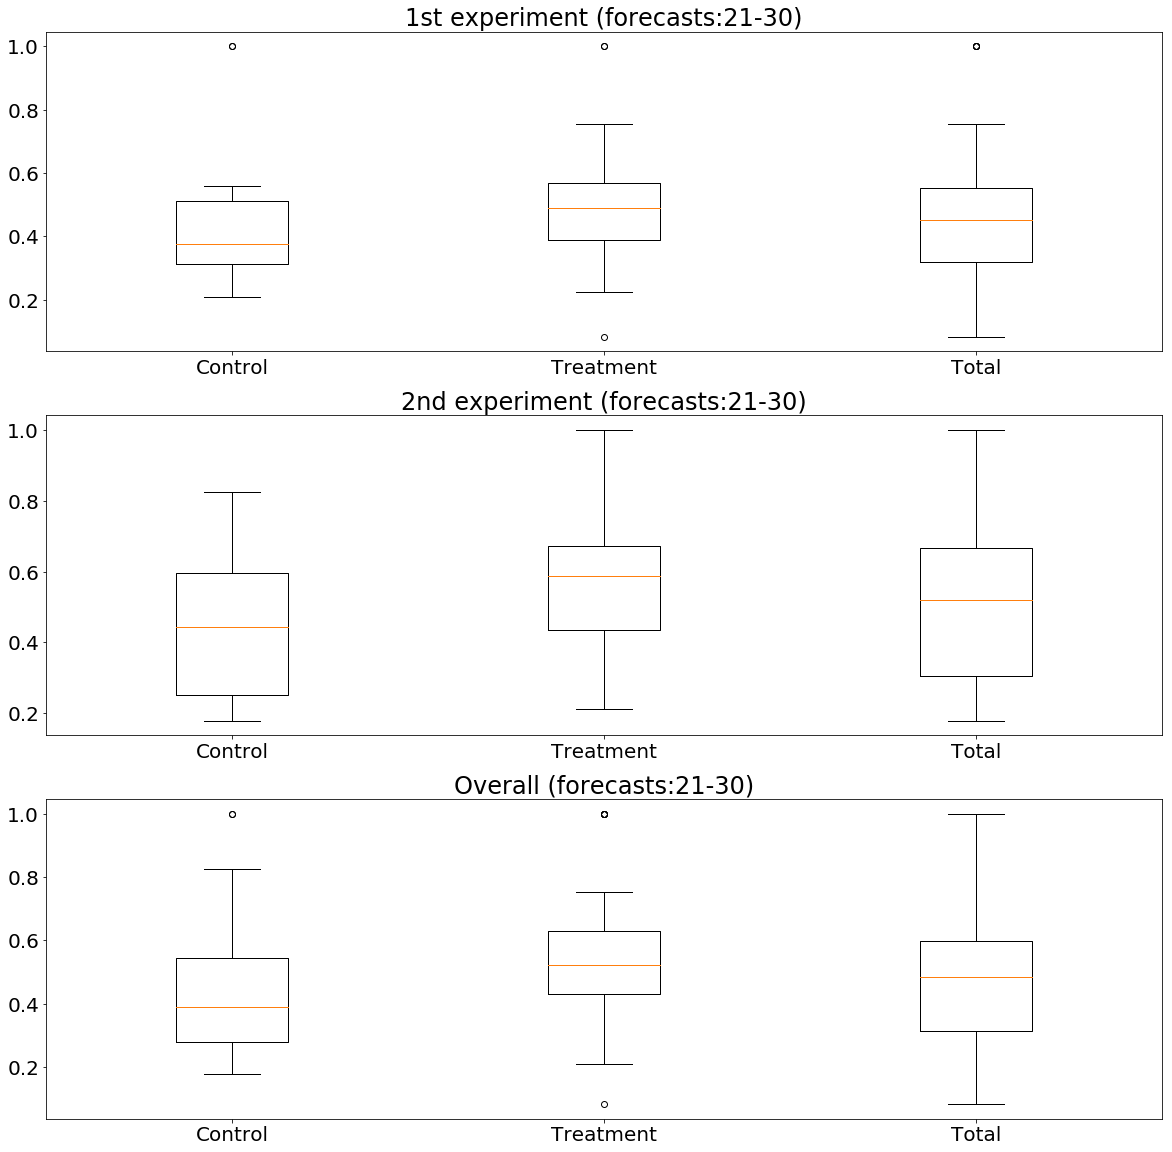

In [59]:
### boxplots for round blocks ###
visualizeBox_follow_algorithm()
visualizeBox_follow_algorithm(0,10)
visualizeBox_follow_algorithm(11,20)
visualizeBox_follow_algorithm(21,30)

((array([-1.77709673, -1.33087857, -1.05345661, -0.83977496, -0.6589352 ,
         -0.49749478, -0.34812942, -0.20618578, -0.06829777,  0.06829777,
          0.20618578,  0.34812942,  0.49749478,  0.6589352 ,  0.83977496,
          1.05345661,  1.33087857,  1.77709673]),
  array([0.33436662, 0.34764978, 0.38323764, 0.40469511, 0.41837231,
         0.427784  , 0.44653508, 0.50121999, 0.51936539, 0.52363951,
         0.52421125, 0.53162241, 0.54299213, 0.56862102, 0.58404034,
         0.58849071, 0.60951097, 0.69705964])),
 (0.1021055077286027, 0.4974118831444534, 0.9863168308471664))

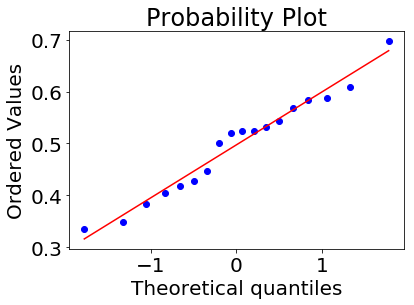

In [60]:
### q-q plot ###

fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(dist_percentage_r1_treat[0:18].mean(1), plot=ax)

In [61]:
### kolmogorov-smirnov test to check for distribution similarity ###
print(stats.ks_2samp(dist_percentage_r1_ctrl.mean(1), dist_percentage_r1_treat.mean(1)))
print(stats.ks_2samp(dist_percentage_r2_ctrl.mean(1), dist_percentage_r2_treat.mean(1)))

### kolmogorov-smirnov test to check for distribution similarity with normal dist ###
print(stats.kstest(dist_percentage_r1_ctrl.mean(1), "norm"))
print(stats.kstest(dist_percentage_r2_ctrl.mean(1), "norm"))
print(stats.kstest(dist_percentage_r1_treat.mean(1), "norm"))
print(stats.kstest(dist_percentage_r2_treat.mean(1), "norm"))



Ks_2sampResult(statistic=0.20833333333333337, pvalue=0.6776664455210043)
Ks_2sampResult(statistic=0.45, pvalue=0.023213275854449572)
KstestResult(statistic=0.5857175174039069, pvalue=4.6924547802973393e-07)
KstestResult(statistic=0.5556958423339697, pvalue=2.437598198179458e-06)
KstestResult(statistic=0.5958897773072143, pvalue=1.1487826689915437e-08)
KstestResult(statistic=0.6055887210362804, pvalue=1.4686741889313737e-07)


In [66]:
### create dataframe for easy seaborn plotting ###

woa_df = pd.DataFrame(data=dist_percentage_total)
woa_df2 = pd.DataFrame(data=pd.DataFrame(data=dist_percentage_total).mean(1))
woa_df_ctrl = pd.DataFrame(data=pd.DataFrame(data=dist_percentage_r1_ctrl).mean(1))
woa_df_treat = pd.DataFrame(data=pd.DataFrame(data=dist_percentage_r1_treat).mean(1))
woa_df_ctrl_fb = pd.DataFrame(data=pd.DataFrame(data=dist_percentage_r2_ctrl).mean(1))
woa_df_treat_fb = pd.DataFrame(data=pd.DataFrame(data=dist_percentage_r2_treat).mean(1))

woa_df_ctrl['x_axis'] = 0*np.ones(20)
woa_df_treat['x_axis'] = np.ones(24)
woa_df_ctrl_fb['x_axis'] = 0*np.ones(20)
woa_df_treat_fb['x_axis'] = np.ones(20)

woa_all = pd.concat([woa_df_ctrl,woa_df_treat,woa_df_ctrl_fb,woa_df_treat_fb])

woa_df_ctrl['y_axis'] = 0*np.ones(20)
woa_df_treat['y_axis'] = 0*np.ones(24)
woa_df_ctrl_fb['y_axis'] = np.ones(20)
woa_df_treat_fb['y_axis'] = np.ones(20)

woa_all['y_axis'] = 2*np.ones(84)

woa_all2 = pd.concat([woa_df_ctrl,woa_df_treat,woa_df_ctrl_fb,woa_df_treat_fb,woa_all])
woa_all2.rename(index=str, columns={"0": "val"})
woa_all2['O']=woa_all2.iloc[:,0]
woa_all2

,0,x_axis,y_axis,O
0,0.753224,0.0,0.0,0.753224
1,0.586246,0.0,0.0,0.586246
2,0.216248,0.0,0.0,0.216248
3,1.000000,0.0,0.0,1.000000
4,0.384762,0.0,0.0,0.384762
5,0.435304,0.0,0.0,0.435304
6,0.496183,0.0,0.0,0.496183
7,0.502276,0.0,0.0,0.502276
8,0.416705,0.0,0.0,0.416705
9,0.364134,0.0,0.0,0.364134


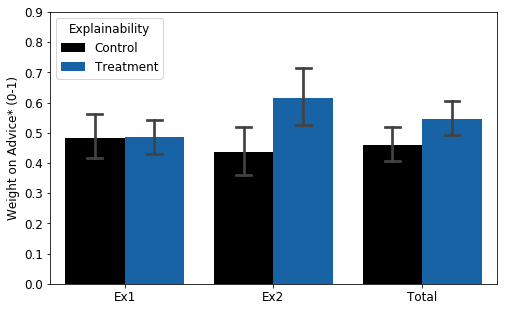

In [68]:
### plot WOA*s for groups ###

tick_labels_box = ["Ex1", "Ex2", "Total"]
fig = plt.figure(figsize=(8,5))
ax = sns.barplot(x="y_axis", y="O", hue="x_axis", data=woa_all2, palette =["#000000","#0065BD"], capsize=.1)
ax.set(xlabel='', ylabel='Weight on Advice* (0-1)')#, title="WOA* barplot ")
ax.set_xticklabels(tick_labels_box)
ax.set_ylim([0,0.9])
ax.legend(loc='upper left')    
legend = ax.legend_
legend.set_title("Explainability")
for t, l in zip(legend.texts,("Control", "Treatment")):
    t.set_text(l)
plt.rcParams.update({'font.size': 12})
# uncomment to safe figure
#plt.savefig("woaBarplot.eps", bbox_inches="tight")

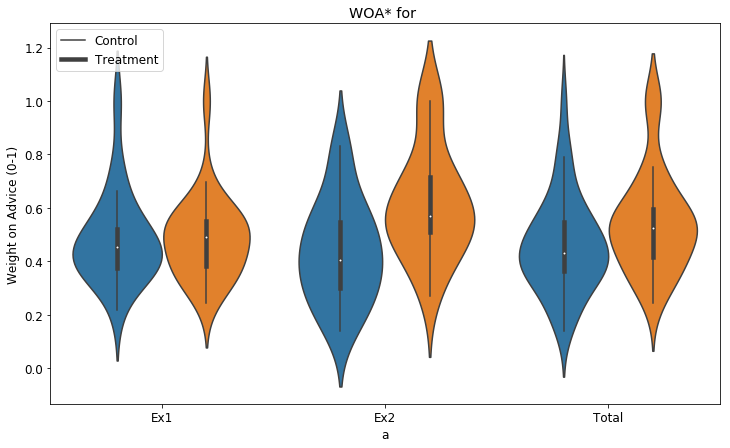

In [69]:
### as violin plot ###

fig = plt.figure(figsize=(12,7))
ax = sns.violinplot(x="y_axis", y="O", hue="x_axis", data=woa_all2)
ax.set(xlabel='a', ylabel='Weight on Advice (0-1)', title="WOA* for ")
ax.set_xticklabels(tick_labels_box)
ax.legend(labels=['Control', 'Treatment'], loc='upper left')
plt.rcParams.update({'font.size': 18})

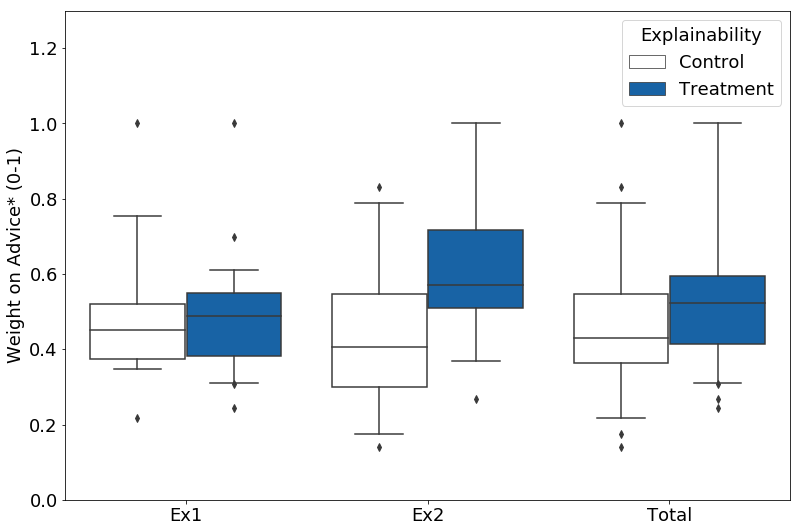

In [70]:
### as boxplot ###

fig = plt.figure(figsize=(13,9))
ax = sns.boxplot(x="y_axis", y="O", hue="x_axis", data=woa_all2, palette =["#FFFFFF","#0065BD"], whis=[5, 95])
ax.set(xlabel='', ylabel='Weight on Advice* (0-1)')#, title="WOA* boxplot ")
ax.set_xticklabels(tick_labels_box)
ax.set_ylim([0,1.3])
ax.legend(loc='best')    
legend = ax.legend_
legend.set_title("Explainability")
for t, l in zip(legend.texts,("Control", "Treatment")):
    t.set_text(l)

#ax.legend(labels=['Control', 'Treatment'], loc='upper left')
plt.rcParams.update({'font.size': 18})
# uncomment to safe figure
#plt.savefig("woaBoxplot.eps", bbox_inches="tight")

In [71]:
### remove WOA* = 1 participants ###
idx_remove_r1_ctrl = np.where(dist_percentage_r1_ctrl.mean(1)==1)
idx_remove_r1_treat = np.where(dist_percentage_r1_treat.mean(1)==1)
idx_remove_r2_treat =np.where(dist_percentage_r2_treat.mean(1)==1)


r1_ctrl = list(filter(lambda x : x != 1, dist_percentage_r1_ctrl.mean(1)))
r1_treat = list(filter(lambda x : x != 1, dist_percentage_r1_treat.mean(1)))
r2_ctrl = list(filter(lambda x : x != 1, dist_percentage_r2_ctrl.mean(1)))
r2_treat = list(filter(lambda x : x != 1, dist_percentage_r2_treat.mean(1)))

### Mann Whiteney U test ###
### explainability effect ###
print('Mean/SD:', np.mean(r1_ctrl), np.std(r1_ctrl))
print('Mean/SD:', np.mean(r1_treat), np.std(r1_treat))
print('Mean/SD:', np.mean(r2_ctrl), np.std(r2_ctrl))
print('Mean/SD:', np.mean(r2_treat), np.std(r2_treat))
print(stats.mannwhitneyu(r1_ctrl, r1_treat, alternative="two-sided"))
print(stats.mannwhitneyu(r2_ctrl, r2_treat, alternative="two-sided"))

print(cohend(r1_ctrl, r1_treat))
print(cohend(r2_ctrl, r2_treat))

Mean/SD: 0.45636821584474707 0.12076801352130191
Mean/SD: 0.4638339186477004 0.11184559754419875
Mean/SD: 0.4373764182957551 0.18574994873625086
Mean/SD: 0.5482670965814342 0.12953952693100768
MannwhitneyuResult(statistic=200.0, pvalue=0.6492020983225945)
MannwhitneyuResult(statistic=102.0, pvalue=0.03967308436596981)
-0.0628263248519683
-0.6642834807788233


In [72]:
### Mann Whiteney U test ###
### explainability effect ###
print(stats.mannwhitneyu(r1_ctrl, r2_ctrl, alternative="two-sided"))
print(stats.mannwhitneyu(r1_treat, r2_treat, alternative="two-sided"))

print(cohend(r1_ctrl, r2_ctrl))
print(cohend(r1_treat, r2_treat))

MannwhitneyuResult(statistic=206.0, pvalue=0.6631905386384751)
MannwhitneyuResult(statistic=124.0, pvalue=0.05207246872253589)
0.11746664871897725
-0.6875957179581512
